In [29]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import *
import torch
import torch.optim as optim

from fastai import *
from fastai.text import *

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


In [31]:
# export

from fastai.callbacks import *
from transformers import AdamW
from functools import partial


from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import GPT2PreTrainedModel, GPT2Tokenizer, GPT2Config

In [32]:
import pdb

In [33]:
DATA = Path(os.getcwd())/'Data'


In [4]:
from exp.nb_XLNET import *

# Load the data

## Agnews

In [11]:
DATA = Path(os.getcwd())/'Data'

In [12]:
AG_NEWS = Path(os.getcwd())/'Data'/'Ag_news'
header = ['class', 'title', 'describ']

class_dict = {1: 'world', 
             2: 'sports',
             3: 'business',
             4: 'sci_tech'}

#AG_NEWS_TRAIN.to_feather(AG_NEWS/'training_30k')
AG_NEWS_TRAIN = pd.read_feather(AG_NEWS/'training_30k')
AG_NEWS_TRAIN['class'] = AG_NEWS_TRAIN['class'].map(class_dict)
AG_NEWS_TRAIN = AG_NEWS_TRAIN.sample(10000, axis= 0)
AG_NEWS_TRAIN = AG_NEWS_TRAIN.reset_index()
AG_NEWS_TRAIN = AG_NEWS_TRAIN.iloc[:, 1:4]
AG_NEWS_TRAIN.shape
#AG_NEWS_TRAIN.head()

(10000, 3)

In [17]:
AG_NEWS_TRAIN['class'].unique()

array(['sports', 'world', 'sci_tech', 'business'], dtype=object)

In [7]:
train = AG_NEWS_TRAIN

## DBpedia data

In [43]:

DBPEDIA = DATA/'Dbpedia'

DBPEDIA_TRAIN = pd.read_feather(DBPEDIA/'training_30k')
# read in the class dict
with open(DBPEDIA/'classes.txt', 'r') as f:
    class_ls = f.readlines()

class_ls = [re.sub('\n', "", i) for i in class_ls]

class_dict = {k:v for k, v in enumerate(class_ls)}

DBPEDIA_TRAIN['class'] = DBPEDIA_TRAIN['class'].map(class_dict) # The data has been class transformed
DBPEDIA_TRAIN = DBPEDIA_TRAIN[DBPEDIA_TRAIN['class'].notnull()] # mislabled one class in original dataset; filtered out here
DBPEDIA_TRAIN = DBPEDIA_TRAIN.sample(10000, axis= 0)
DBPEDIA_TRAIN = DBPEDIA_TRAIN.reset_index(drop = True)

print(DBPEDIA_TRAIN['class'].unique()) # 13 unique values
DBPEDIA_TRAIN.shape

['Athlete' 'Film' 'Building' 'Album' 'Artist' 'EducationalInstitution' 'Plant' 'MeanOfTransportation' 'NaturalPlace'
 'WrittenWork' 'Village' 'OfficeHolder' 'Animal']


(10000, 3)

## YELP data

In [34]:
DATA = Path(os.getcwd())/'Data'

YELP = DATA/'Yelp'

YELP_TRAIN = pd.read_feather(YELP/'training_10k')
YELP_TRAIN.head(2)

class                                              title
0      1  The apartment I rented was infested with scorp...
1      4  It seems like other folks had different experi...

## Amazon data

In [6]:
AMAZON = DATA/'Amazon_full'
AMAZON_TRAIN = pd.read_feather(AMAZON/'training_10k')
AMAZON_TRAIN.head(2)

class                     title  \
0      1       Kindle version only   
1      4  A Perfect Family Film!!!   

                                              review  
0  From reading the other comments the book sound...  
1  This was a really good movie about a little gi...

## Customer data

In [6]:
CUSTOMER = DATA/'Customer'
CUSTOMER_TRAIN = pd.read_feather(CUSTOMER/'training_10k')
CUSTOMER_TRAIN.head()

product  \
0                                    Debt collection   
1  Credit reporting, credit repair services, or o...   
2                                           Mortgage   
3  Credit reporting, credit repair services, or o...   
4  Credit reporting, credit repair services, or o...   

                                           complaint  
0  For over a month, I have been getting calls fr...  
1  XX/XX/XXXX, a series on letters to XXXX XXXX X...  
2  I recently received a statement from Wells Far...  
3  I have been disputing XXXX XXXX XXXX account i...  
4  I have several student loans on my account, in...

In [23]:
len(CUSTOMER_TRAIN['product'].unique()) # 18 unique values

18

# Set up the processors

In [35]:
# export
class GPT2ClassificationHeadModel(GPT2PreTrainedModel):

    def __init__(self, config, clf_dropout=0.4, n_class=8):
        super(GPT2ClassificationHeadModel, self).__init__(config)
        self.transformer = GPT2Model(config)
        self.dropout = nn.Dropout(clf_dropout)
        self.linear = nn.Linear(config.n_embd * 2, n_class)

        nn.init.normal_(self.linear.weight, std = 0.02)
        nn.init.normal_(self.linear.bias, 0)

        self.apply(self.init_weights)


    def forward(self, input_ids, position_ids=None, token_type_ids=None, lm_labels=None, past=None):
        hidden_states, presents = self.transformer(input_ids, position_ids, token_type_ids, past)
        avg_pool = torch.mean(hidden_states, 1)
        max_pool, _ = torch.max(hidden_states, 1)
        h_conc = torch.cat((avg_pool, max_pool), 1)
        logits = self.linear(self.dropout(h_conc))
        return logits

In [36]:
# export

MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'gpt2': ((GPT2ClassificationHeadModel, GPT2Tokenizer, GPT2Config ))
}

In [37]:
# export

# Parameters
seed = 42
use_fp16 = True
bs = 16

#model_type = 'roberta'
#pretrained_model_name = 'roberta-base'

#model_type = 'bert'
#pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

model_type = 'xlnet'
pretrained_model_name = 'xlnet-base-cased'

#model_type = 'gpt2'
#pretrained_model_name = 'gpt2'

In [38]:
# export

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

model_class.pretrained_model_archive_map

{'xlnet-base-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin',
 'xlnet-large-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-large-cased-pytorch_model.bin'}

In [39]:
# export

class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]
    
    
    

    
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})
        
        
        

# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [40]:
# export

# set up the tokenizer for the processor
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

# set up the numericalizer for the processor
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

# set up the processor
transformer_processor = [tokenize_processor, numericalize_processor]



In [41]:
# export

pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [42]:
# export
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 18

transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

CustomAdamW = partial(AdamW, correct_bias=False)

In [61]:
# tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it is me')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġis', 'Ġme']
[19221, 315, 269, 1556, 6941, 72, 11, 18435, 340, 318, 502]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġis', 'Ġme']

In [16]:
# These are individual steps that are included in the algorithum_looper_dl function
# databunch = (TextList.from_df(train, cols='describ', processor=transformer_processor)
#              .split_by_rand_pct(0.2)
#              .label_from_df(cols= 'class')
#              .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

# config = config_class.from_pretrained(pretrained_model_name)
# config.num_labels = 4
# config.use_bfloat16 = use_fp16

# transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# # transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)



# custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [44]:
# def loss_batch_bert(model: nn.Module, xb: Tensor, yb: Tensor, loss_func: OptLossFunc = None, opt: OptOptimizer = None,
#                     cb_handler: Optional[CallbackHandler] = None) -> Tuple[Union[Tensor, int, float, str]]:
#     "Calculate loss and metrics for a batch, call out to callbacks as necessary."
#     cb_handler = ifnone(cb_handler, CallbackHandler())
#     if not is_listy(xb):
#         xb = [xb]
#     if not is_listy(yb):
#         yb = [yb]
#     out = model(*xb)
#     # pdb.set_trace()
#     out = out[0]
#     out = cb_handler.on_loss_begin(out)

#     if not loss_func:
#         return to_detach(out), yb[0].detach()
#     loss = loss_func(out, *yb)

#     if opt is not None:
#         loss, skip_bwd = cb_handler.on_backward_begin(loss)
#         if not skip_bwd:
#             loss.backward()
#         if not cb_handler.on_backward_end():
#             opt.step()
#         if not cb_handler.on_step_end():
#             opt.zero_grad()

#     return loss.detach().cpu()


# # To change the loss_batch function in the loaded fastai module
# module_basic_train = sys.modules['fastai.basic_train']
# module_basic_train.loss_batch = loss_batch_bert
# sys.modules['fastai.basic_train'] = module_basic_train

In [45]:

# #CustomAdamW = partial(AdamW, correct_bias=False)
# loss_func = nn.CrossEntropyLoss()
# learner = Learner(databunch, 
#                   transformer_model, 
#                   opt_func = loss_func, 
#                   metrics=[accuracy, error_rate])

# # Show graph of learner stats and metrics after each epoch.
# learner.callbacks.append(ShowGraph(learner))

# # Put learn in FP16 precision mode. --> Seems to not working
# #if use_fp16: learner = learner.to_fp16()

In [20]:


# CustomAdamW = partial(AdamW, correct_bias=False)
# #loss_func = nn.CrossEntropyLoss()
# learner = Learner(databunch, 
#                   custom_transformer_model, 
#                   opt_func = CustomAdamW, 
#                   metrics=[accuracy, error_rate])

# # Show graph of learner stats and metrics after each epoch.
# learner.callbacks.append(ShowGraph(learner))

# # Put learn in FP16 precision mode. --> Seems to not working
# if use_fp16: learner = learner.to_fp16()

In [21]:

# export
def algorithum_looper_dl(dataset, label_cols, text_cols, num_class ):
    ''' Loop over the dataset 5 times for XLNet algorithum
    '''
    
    #config = config_class.from_pretrained(pretrained_model_name)
    config.num_labels = num_class
    
    df = dataset
    label_cols = label_cols
    text_cols = text_cols
    #CustomAdamW = partial(AdamW, correct_bias=False)

    accus = []

    # use StratifiedKFold to CV 5 folds 
    for train_idx, val_idx in StratifiedKFold(n_splits=5,  shuffle=True).split(df, df[label_cols]):
        train = df.iloc[train_idx, :]
        val = df.iloc[val_idx, :]
        #transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
        custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)
        torch.cuda.empty_cache()



        databunch = (TextList.from_df(df, cols= text_cols, processor=transformer_processor)
                 .split_by_rand_pct(0.2)
                 .label_from_df(cols= label_cols)
                 .databunch(bs= 16, pad_first=pad_first, pad_idx=pad_idx))
        
        learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])
        
        learner.callbacks.append(ShowGraph(learner))
        
        learner = learner.to_fp16()

        learner.fit_one_cycle(2,  max_lr = slice(1e-05))
        
        _, accu, _ = learner.validate()
        accu = accu.item()
        #pdb.set_trace()
        
        accus.append(accu)
        torch.cuda.empty_cache()
    
    return accus

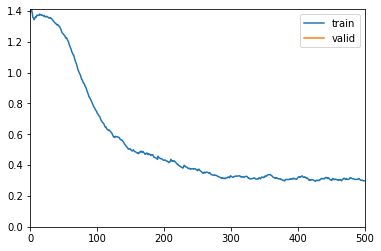

> <ipython-input-55-a2bc06e48c67>(44)algorithum_looper_dl()
-> accus.append(accu)
(Pdb) a
dataset =          class                                              title  \
0        world         Azzam release to improve Egypt-Israel ties   
1     sci_tech  Watch Out! It #39;s all about better connectiv...   
2     sci_tech                    Pioneer, Sharp Let Blu-ray Play   
3     sci_tech                     Tumbleweeds in the Bloodstream   
4       sports                   Blow as Federer quits home event   
...        ...                                                ...   
9995  sci_tech  Bald Eagles Rebound, Other Birds of Prey in Tr...   
9996  business               Crude oil prices top \$US51 a barrel   
9997  business             North Sea oil decline widens trade gap   
9998  sci_tech     Apple warns of store shut-off for older iTunes   
9999  sci_tech           Samsung unveils 5-megapixel camera phone   

                                                describ  
0     Egypt #

(Pdb) learner.validate(
*** SyntaxError: unexpected EOF while parsing
(Pdb) learner.validate()


[0.30844226, tensor(0.8970), tensor(0.1030)]
(Pdb) q


BdbQuit: 

In [56]:
accus_agnews = algorithum_looper_dl(AG_NEWS_TRAIN, 'class', 'describ' , num_class = 4)

In [39]:
torch.cuda.empty_cache()

In [27]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


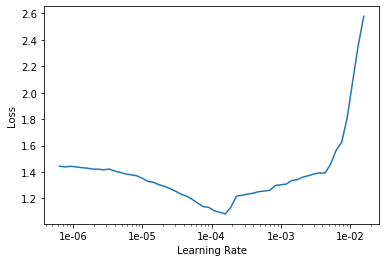

In [28]:
learner.recorder.plot()

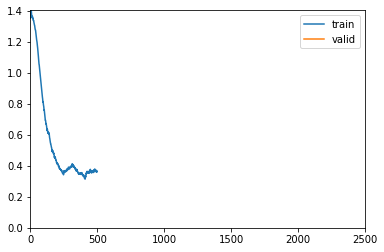

KeyboardInterrupt: 

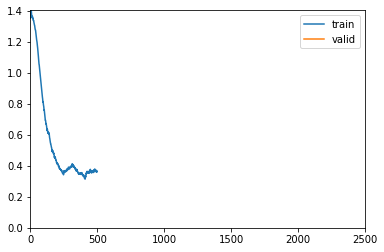

In [21]:
learner.fit_one_cycle(5, max_lr= 3 * 1e-05)

# running stage1

## for Agnews data

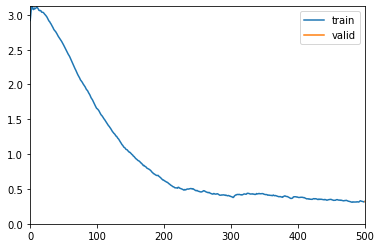

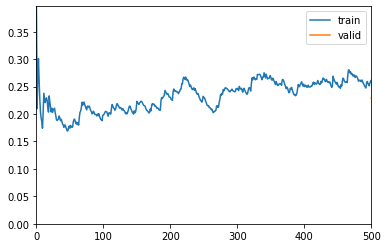

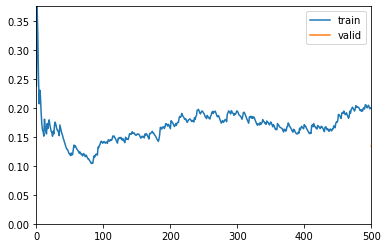

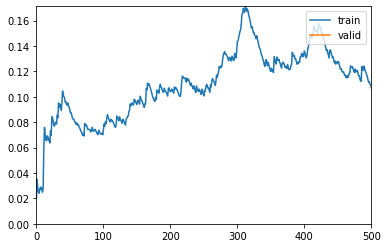

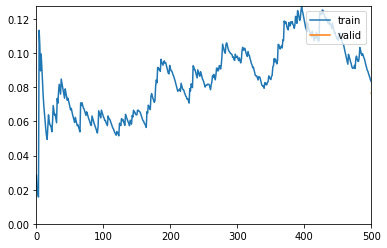

In [22]:
accus_agnews = algorithum_looper_dl(AG_NEWS_TRAIN, 'class', 'describ' , num_class = 4)

In [26]:
accus_agnews

[0.921999990940094,
 0.9440000057220459,
 0.965499997138977,
 0.9725000262260437,
 0.9769999980926514]

In [22]:
torch.cuda.empty_cache()

## for Dbpedia data

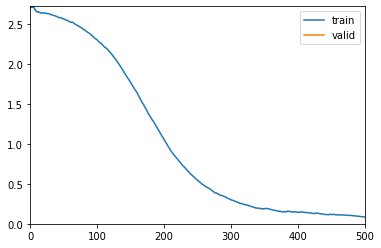

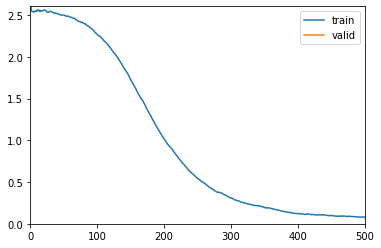

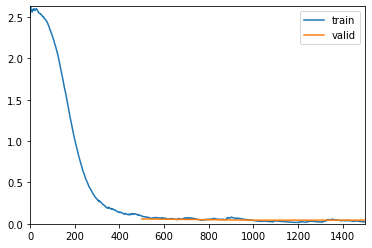

KeyboardInterrupt: 

In [17]:
accus_dbpedia = algorithum_looper_dl(DBPEDIA_TRAIN, 'class', 'contents' , num_class = 13)

In [19]:
#accus_dbpedia = [i.item() for i in accus_dbpedia]
accus_dbpedia = [0.988, 0.988, 0.986, 0.990, 0.990]
xlnet_dbpedia_accu_5 = pd.DataFrame({
    'model_name' : ['xlnet'] * 5,
    'accuracy' : accus_dbpedia
})

xlnet_dbpedia_accu_5.to_csv(DBPEDIA/'xlnet_dbpedia_accu_5', index = False)

In [20]:
xlnet_dbpedia_accu_5

model_name  accuracy
0      xlnet     0.988
1      xlnet     0.988
2      xlnet     0.986
3      xlnet     0.990
4      xlnet     0.990

## Yelp data

In [13]:
torch.cuda.empty_cache()

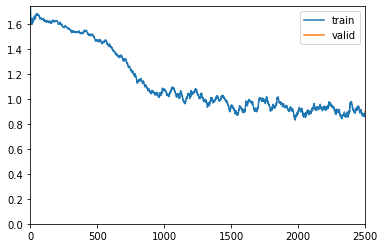

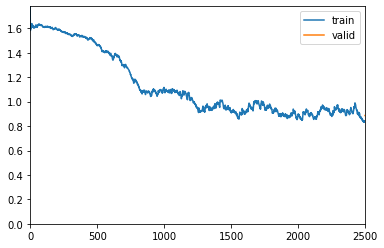

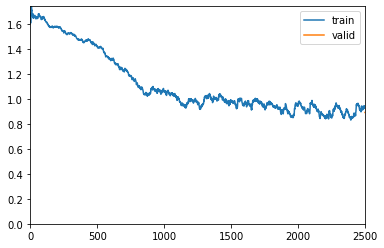

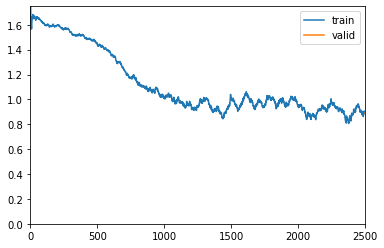

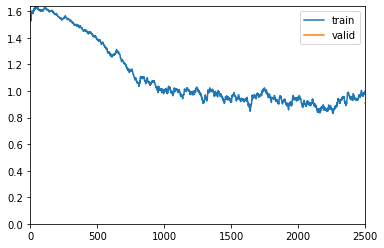

In [14]:
accus_yelp = algorithum_looper_dl(YELP_TRAIN, 'class', 'title' , num_class = 5)

In [18]:
xlnet_yelp_accu_5 = pd.DataFrame({
    'model_name' : ['xlnet'] * 5,
    'accuracy' : accus_yelp
})

xlnet_yelp_accu_5.to_csv(YELP/'xlnet_yelp_accu_5', index = False)

In [19]:
xlnet_yelp_accu_5

model_name  accuracy
0      xlnet    0.6424
1      xlnet    0.6436
2      xlnet    0.6696
3      xlnet    0.6556
4      xlnet    0.6392

In [17]:
accus_yelp 

[0.6424000263214111,
 0.6435999870300293,
 0.6696000099182129,
 0.6556000113487244,
 0.63919997215271]

## Amazon data

In [21]:
accus_amazon = algorithum_looper_dl(AMAZON_TRAIN, 'class', 'review' , num_class = 5)

NameError: name 'AMAZON_TRAIN' is not defined

In [16]:
accus_amazon = [i.item() for i in accus_amazon]

In [17]:
accus_amazon

[0.5888000130653381,
 0.5856000185012817,
 0.5812000036239624,
 0.58160001039505,
 0.5911999940872192]

In [18]:
xlnet_amazon_accu_5 = pd.DataFrame({
    'model_name' : ['xlnet'] * 5,
    'accuracy' : accus_amazon
})

xlnet_amazon_accu_5.to_csv(AMAZON/'xlnet_amazon_accu_5', index = False)

In [20]:
torch.cuda.empty_cache()

## Customer data

In [27]:
accus_customer = algorithum_looper_dl(CUSTOMER_TRAIN, 'product', 'complaint' , num_class = 18)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RuntimeError: CUDA out of memory. Tried to allocate 334.00 MiB (GPU 0; 15.90 GiB total capacity; 14.81 GiB already allocated; 133.88 MiB free; 310.94 MiB cached)

# running stage 2

In [46]:
df = DBPEDIA_TRAIN
df.head(2)

class                          title  \
0  Athlete    Aleksandar Simić (composer)   
1     Film  Cold Blow and the Rainy Night   

                                            contents  
0   Aleksandar Simić (Serbian Cyrillic: Александа...  
1   Cold Blow and the Rainy Night is the third al...

In [72]:
label_cols = 'class'
text_cols = 'contents'

x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(df[text_cols], df[label_cols], range(len(df)), test_size=2000, random_state=0)


train = pd.DataFrame({text_cols: x_train, 
                      label_cols: y_train})
val = pd.DataFrame({text_cols: x_test, 
                      label_cols: y_test})
train = train.reset_index()[[text_cols, label_cols]]
val = val.reset_index()[[text_cols, label_cols]]

train['is_valid'] = 0
val['is_valid'] = 1
#combine two dataframe into one
df_combine = pd.concat([train, val], axis=0)




val

contents  \
0      Warwick Records is a British record label fro...   
1      A Trap for Santa Claus is a 1909 one-reel Ame...   
2      Eleazer Goulding House is a historic house at...   
3      Chionanthus porcatus grows as a tree up to 30...   
4      Sabine Baeß married Marbach (born 15 March 19...   
...                                                 ...   
1995   The James Craig is a three-masted iron-hulled...   
1996   Fewlass Llewellyn (born 5 March 1886 in Hull ...   
1997   Hamamelidaceae commonly referred to as the wi...   
1998   The Santarosa Modulo (also known as the SR Mo...   
1999   Bridgepoint Education is a San Diego Californ...   

                       class  is_valid  
0     EducationalInstitution         1  
1                WrittenWork         1  
2               NaturalPlace         1  
3                      Album         1  
4               OfficeHolder         1  
...                      ...       ...  
1995                Building         1  
1996                 Athlete         1  
1997                   Album         1  
1998                Building         1  
1999  EducationalInstitution         1  

[2000 rows x 3 columns]

(8000, 3)

In [45]:
# export
def xlnet_training_size_looper_dl(size: list, path,  df_combine, num_labels, text_cols = text_cols, label_cols = label_cols,   bs = 4):
    """Loop over a dataset with varying training size and algorithums and returns a dataframe.


    """

    accus = []
    for n in size:
        # sub sample n first


        boot_num = 5

        for i in range(boot_num):
            train = df_combine.loc[df_combine['is_valid'] == 0, :]
            index = np.random.randint(0, len(train), n)
            val = df_combine.loc[df_combine['is_valid'] == 1, :]
            sub_train = train.iloc[index, :].reset_index(drop=True)
            
            # concat sub_train and val together
            sub_df_combine = pd.concat([sub_train, val], axis=0)
            transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

            custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)
            torch.cuda.empty_cache()

            databunch = (TextList.from_df(sub_df_combine, cols= text_cols, processor=transformer_processor)
                     .split_from_df(col='is_valid')
                     .label_from_df(cols= label_cols)
                     .databunch(bs= bs, pad_first=pad_first, pad_idx=pad_idx))

            


            learner = Learner(databunch, 
                      custom_transformer_model, 
                      opt_func = CustomAdamW, 
                      metrics=[accuracy, error_rate])
        
            learner.callbacks.append(ShowGraph(learner))

            learner = learner.to_fp16()

            learner.fit_one_cycle(3,  max_lr = slice(1e-05/3))
            learner.fit_one_cycle(1, max_lr = 1e-05/10 )

            _, accu, _ = learner.validate()
            accu = accu.item()

            #pdb.set_trace()

            #accus.append(accu)


            accus.append(("xlnet", n, accu))
            print(
                f'finished {i}th bootstrap of size{n}')
            torch.cuda.empty_cache()

    return pd.DataFrame(accus, columns=['model_name', 'training_size', 'accuracy'])

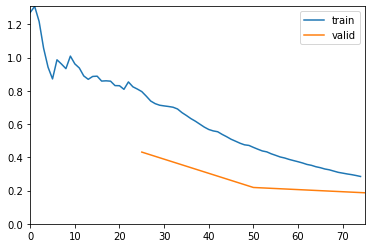

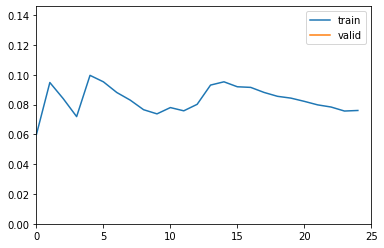

finished 0th bootstrap of size100


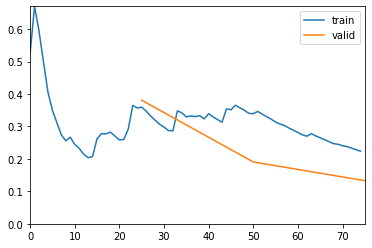

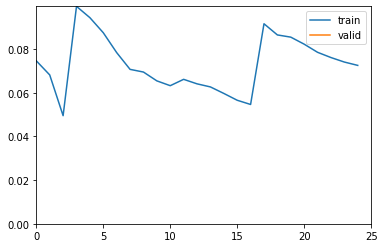

finished 1th bootstrap of size100


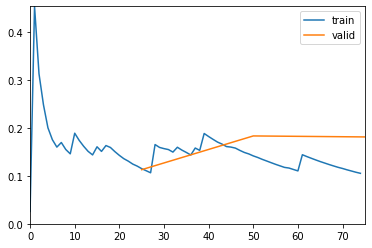

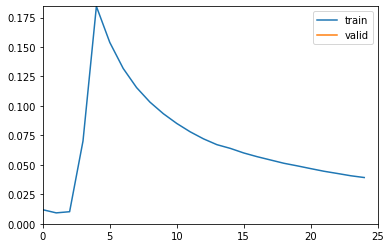

finished 2th bootstrap of size100


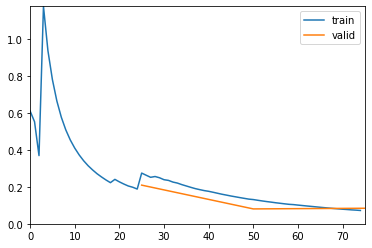

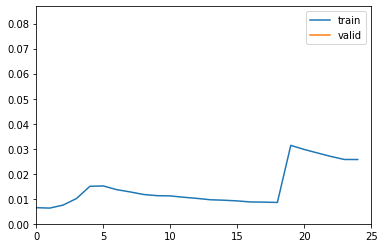

finished 3th bootstrap of size100


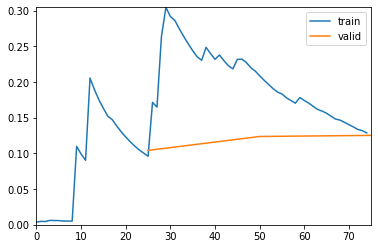

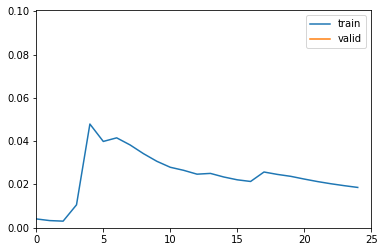

finished 4th bootstrap of size100


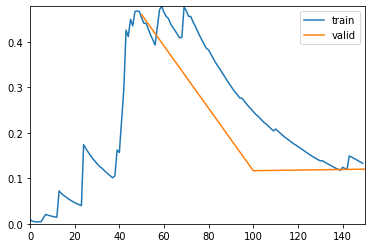

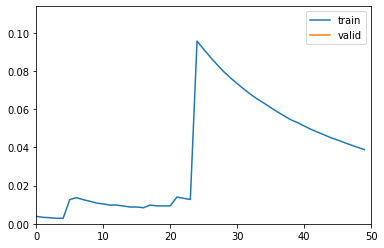

finished 0th bootstrap of size200


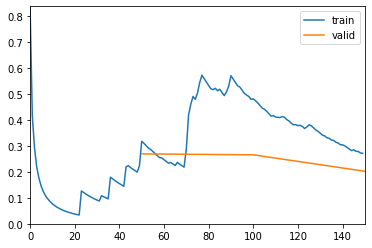

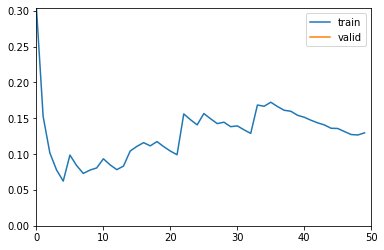

finished 1th bootstrap of size200


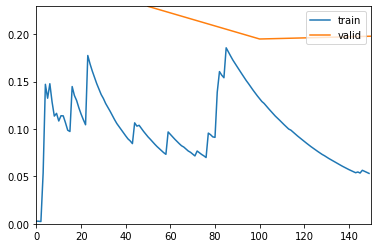

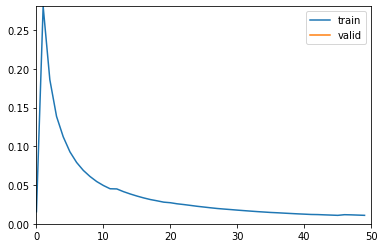

finished 2th bootstrap of size200


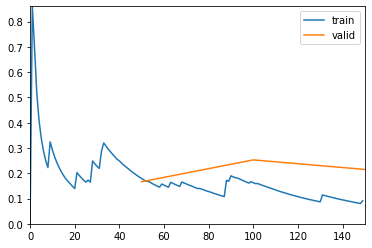

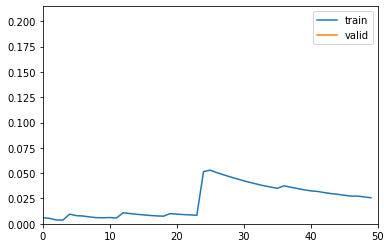

finished 3th bootstrap of size200


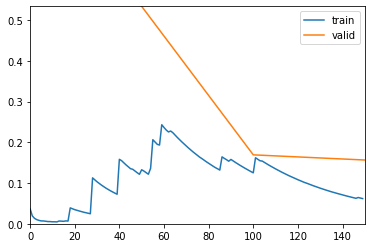

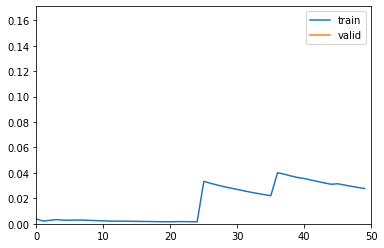

finished 4th bootstrap of size200


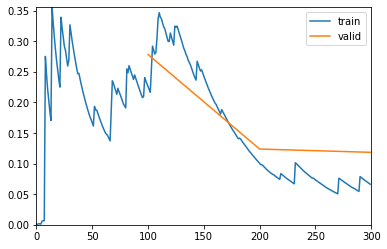

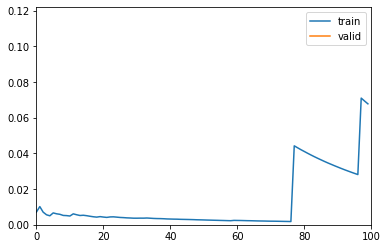

finished 0th bootstrap of size400


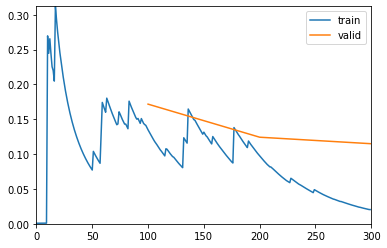

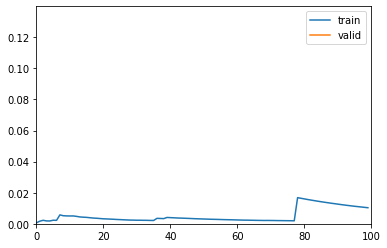

finished 1th bootstrap of size400


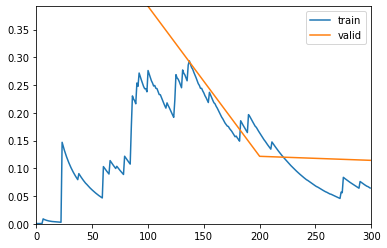

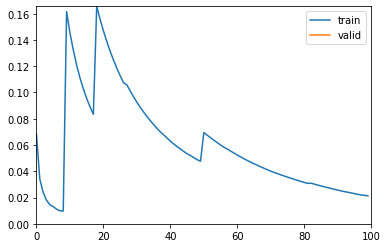

finished 2th bootstrap of size400


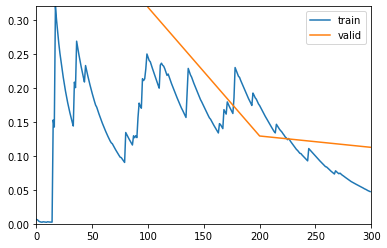

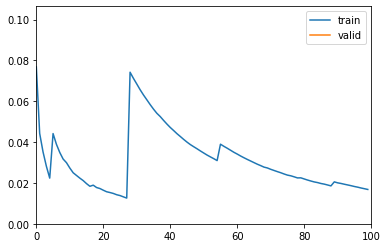

finished 3th bootstrap of size400


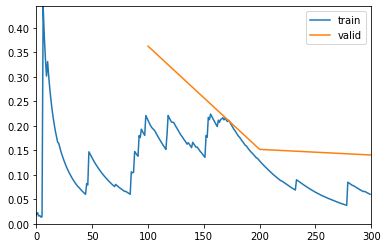

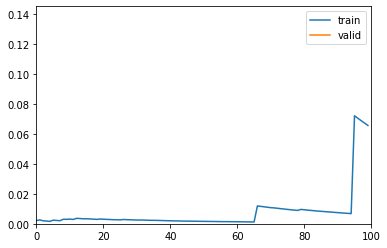

finished 4th bootstrap of size400


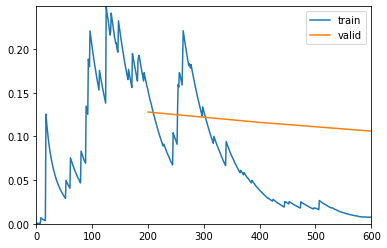

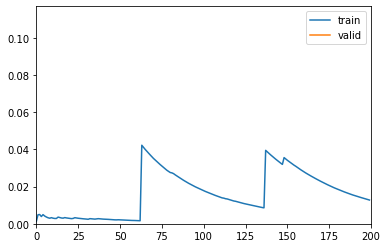

finished 0th bootstrap of size800


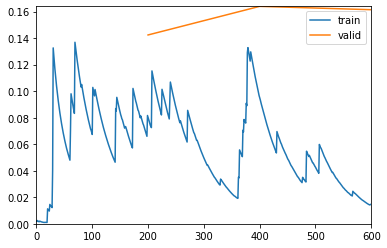

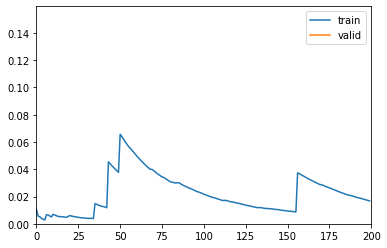

finished 1th bootstrap of size800


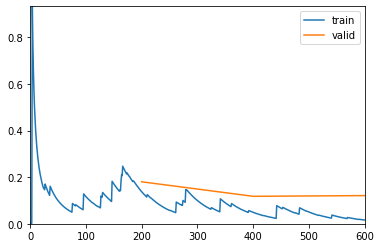

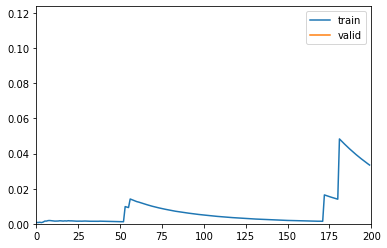

finished 2th bootstrap of size800


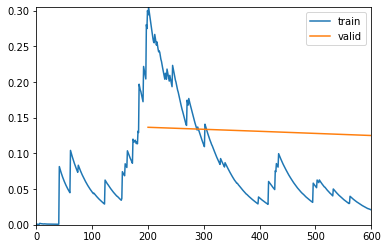

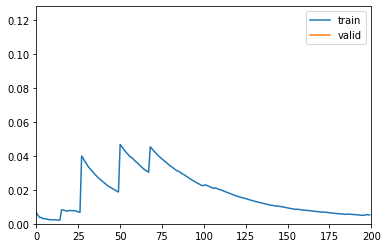

finished 3th bootstrap of size800


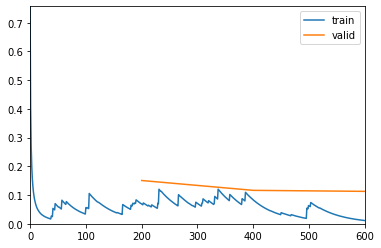

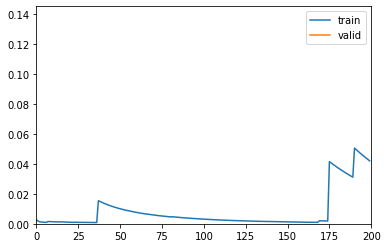

finished 4th bootstrap of size800


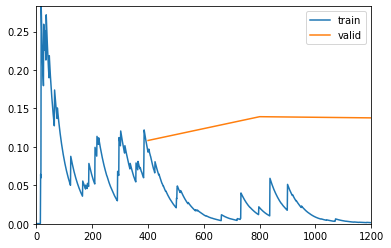

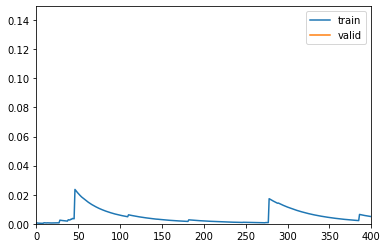

finished 0th bootstrap of size1600


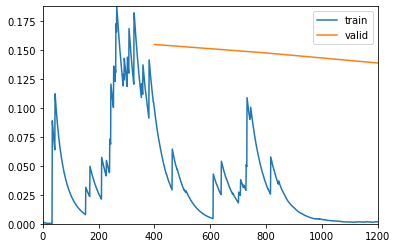

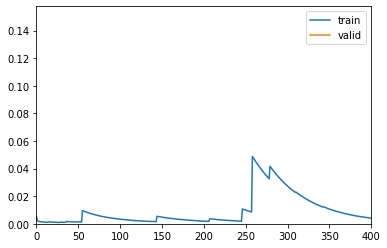

finished 1th bootstrap of size1600


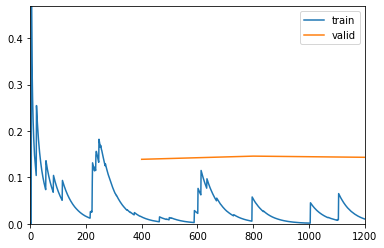

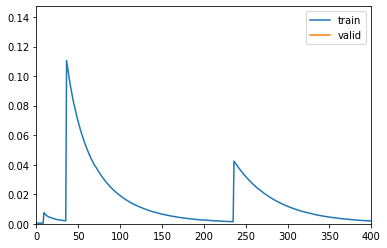

finished 2th bootstrap of size1600


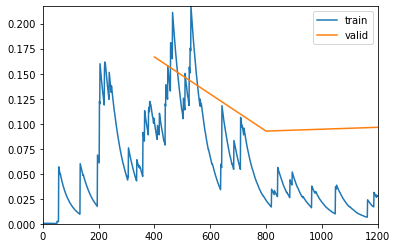

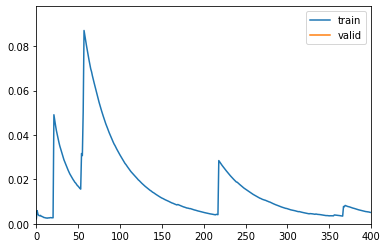

finished 3th bootstrap of size1600


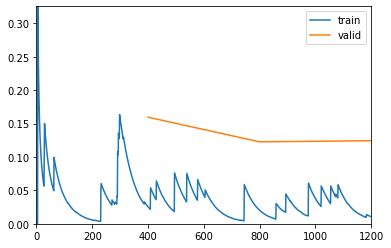

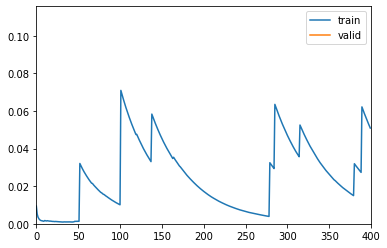

finished 4th bootstrap of size1600


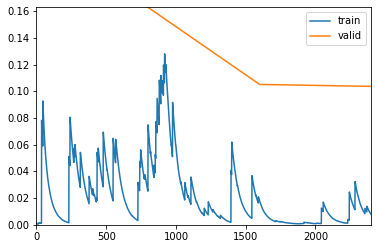

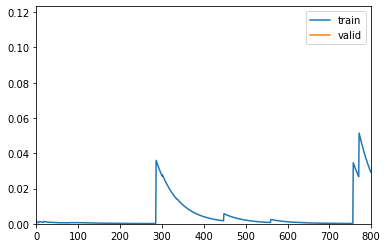

finished 0th bootstrap of size3200


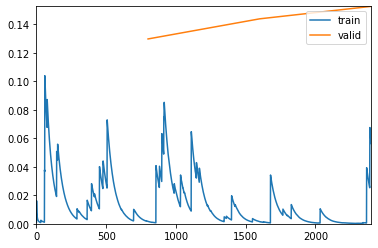

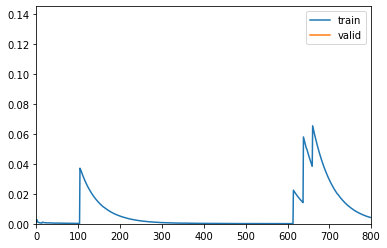

finished 1th bootstrap of size3200


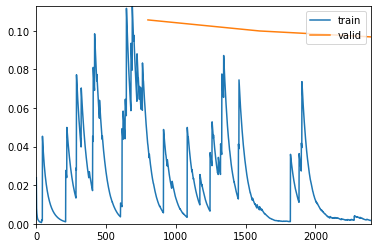

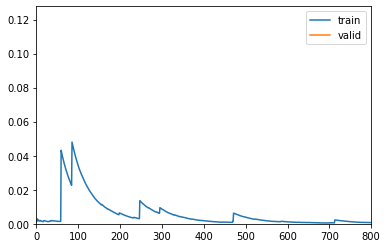

finished 2th bootstrap of size3200


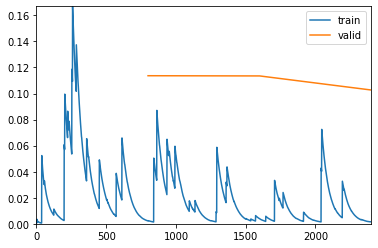

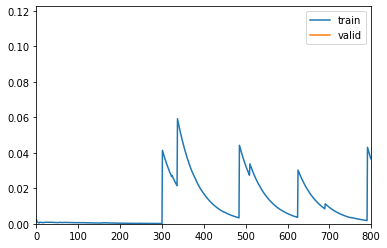

finished 3th bootstrap of size3200


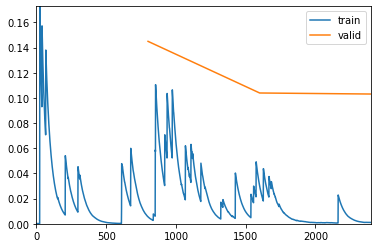

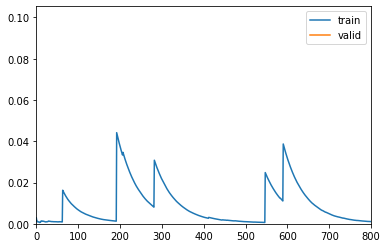

finished 4th bootstrap of size3200


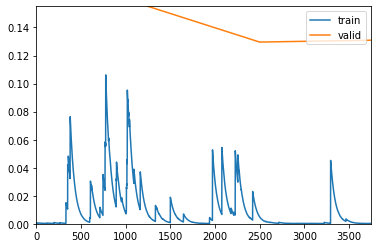

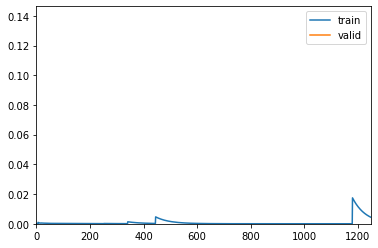

finished 0th bootstrap of size5000


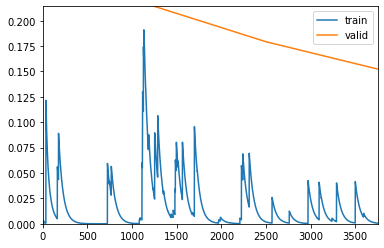

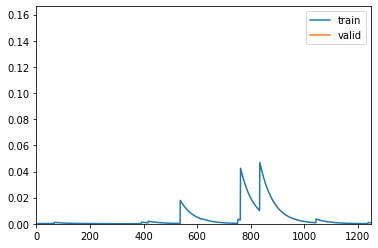

finished 1th bootstrap of size5000


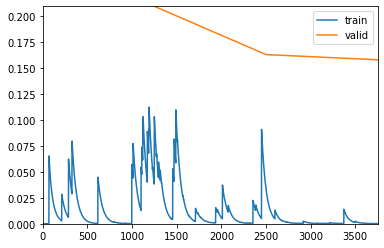

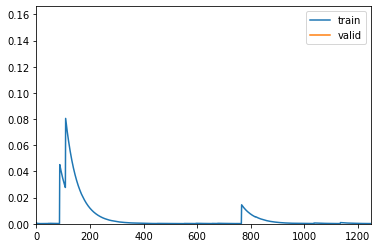

finished 2th bootstrap of size5000


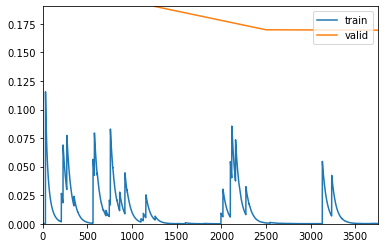

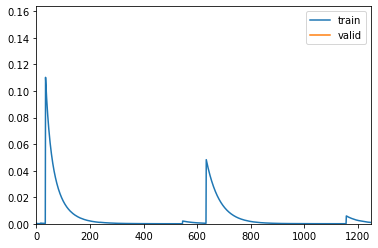

finished 3th bootstrap of size5000


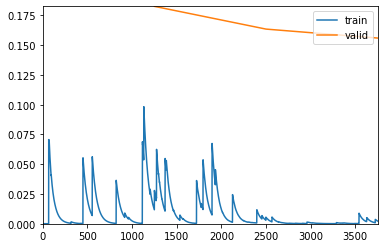

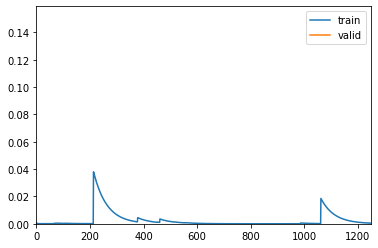

finished 4th bootstrap of size5000


ValueError: Shape of passed values is (70, 1), indices imply (70, 3)

In [77]:
res_dbpedia = xlnet_training_size_looper_dl([100, 200, 400, 800, 1600, 3200, 5000],  DBPEDIA, df_combine , 13 )

In [78]:
res_dbpedia

NameError: name 'res_dbpedia' is not defined

In [81]:

torch.cuda.empty_cache()

## Yelp data

In [43]:
df = YELP_TRAIN
df.head(2)

class                                              title
0      1  The apartment I rented was infested with scorp...
1      4  It seems like other folks had different experi...

In [44]:
label_cols = 'class'
text_cols = 'title'

x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(df[text_cols], df[label_cols], range(len(df)), test_size=2000, random_state=0)


train = pd.DataFrame({text_cols: x_train, 
                      label_cols: y_train})
val = pd.DataFrame({text_cols: x_test, 
                      label_cols: y_test})
train = train.reset_index()[[text_cols, label_cols]]
val = val.reset_index()[[text_cols, label_cols]]

train['is_valid'] = 0
val['is_valid'] = 1
#combine two dataframe into one
df_combine = pd.concat([train, val], axis=0)
val

title  class  is_valid
0     We ordered half white and half regular large p...      2         1
1     Yummy food! Which is the main thing.\nNegative...      3         1
2     My girlfriend and I went in to get a very pers...      5         1
3     This place is right next to my work building, ...      4         1
4     I love the burgers here and the fries are pret...      3         1
...                                                 ...    ...       ...
1995  Good food but this place needs to be boycotted...      1         1
1996  This review of Pacific Blue Pools is a easy on...      5         1
1997  When this place bothers to have a selection, t...      1         1
1998  The best french food I've ever had! Amazing fo...      4         1
1999  Emergency room....BAD experience twice in 3 yr...      1         1

[2000 rows x 3 columns]

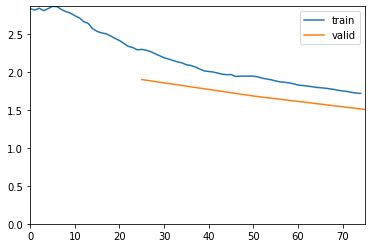

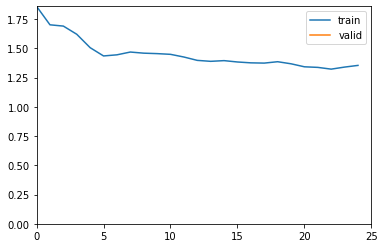

finished 0th bootstrap of size100


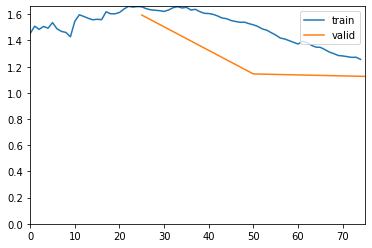

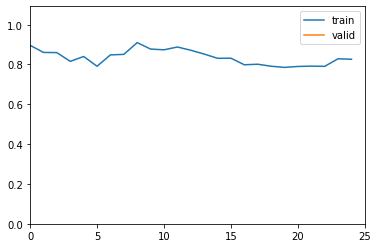

finished 1th bootstrap of size100


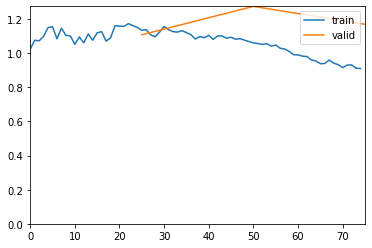

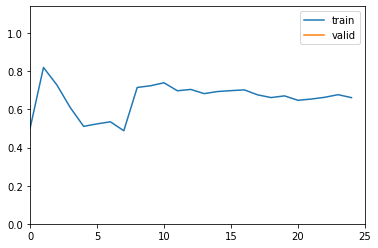

finished 2th bootstrap of size100


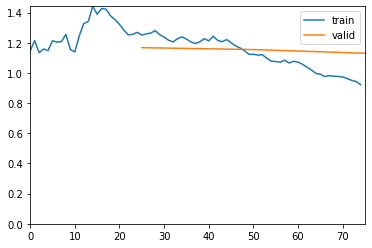

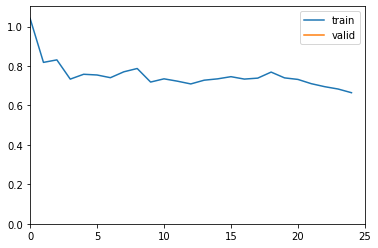

finished 3th bootstrap of size100


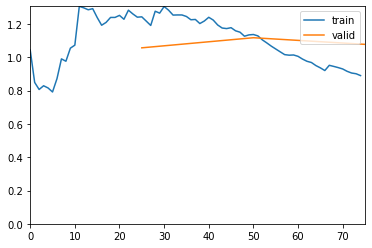

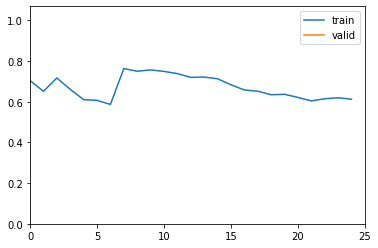

finished 4th bootstrap of size100


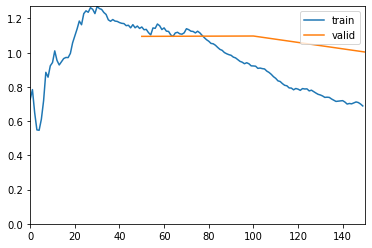

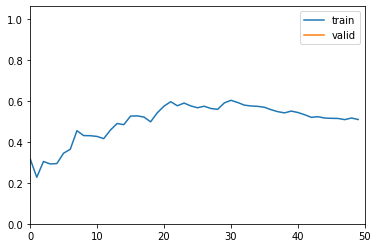

finished 0th bootstrap of size200


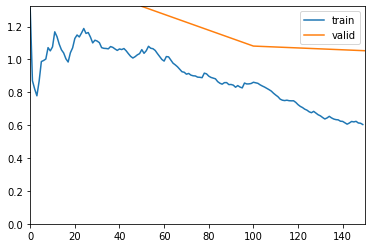

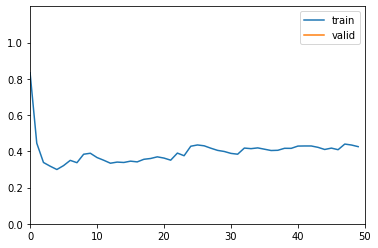

finished 1th bootstrap of size200


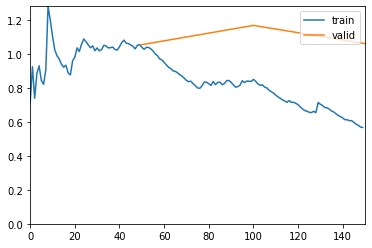

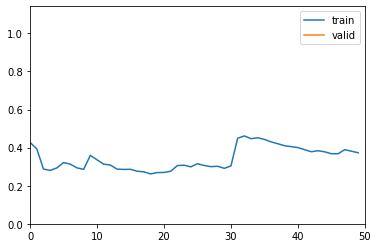

finished 2th bootstrap of size200


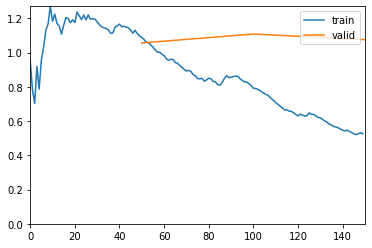

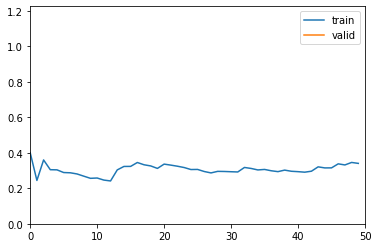

finished 3th bootstrap of size200


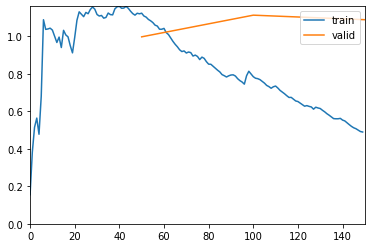

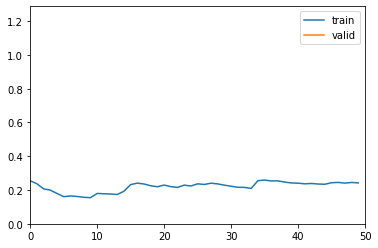

finished 4th bootstrap of size200


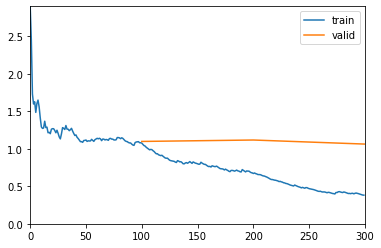

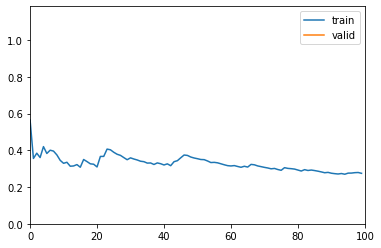

finished 0th bootstrap of size400


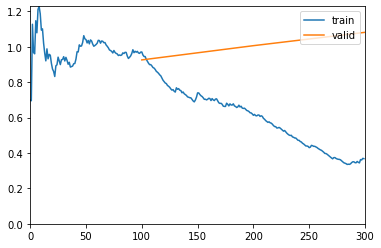

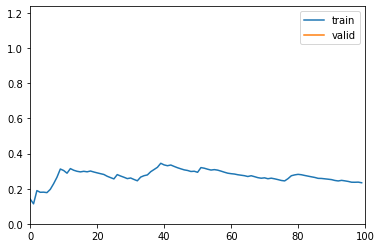

finished 1th bootstrap of size400


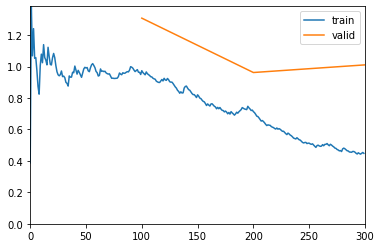

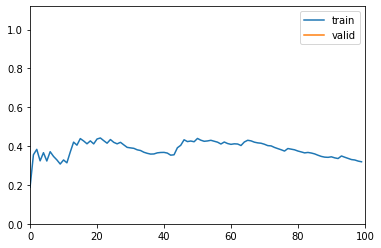

finished 2th bootstrap of size400


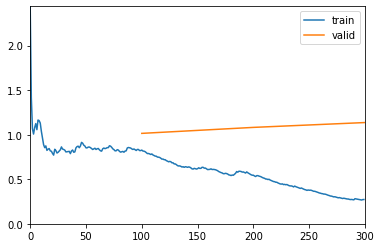

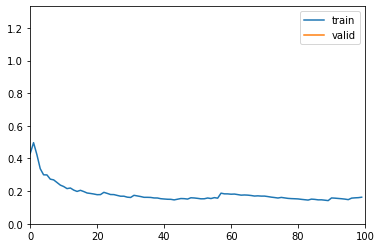

finished 3th bootstrap of size400


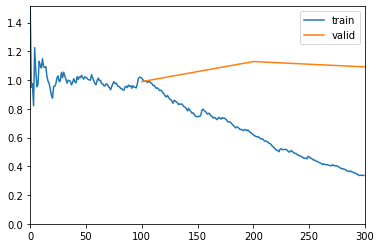

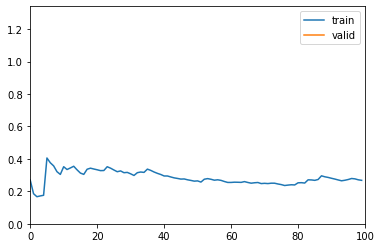

finished 4th bootstrap of size400


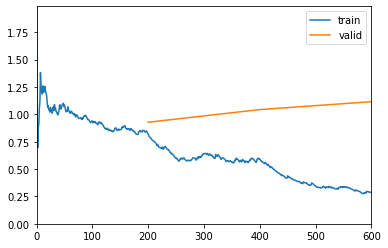

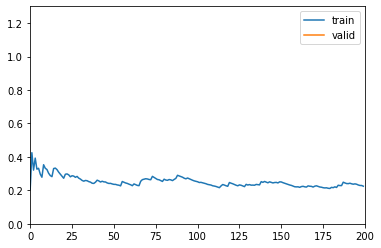

finished 0th bootstrap of size800


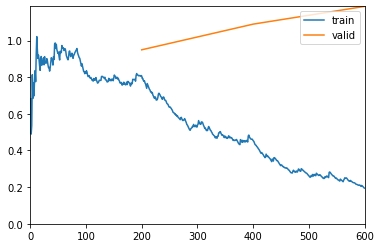

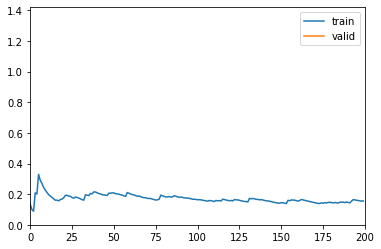

finished 1th bootstrap of size800


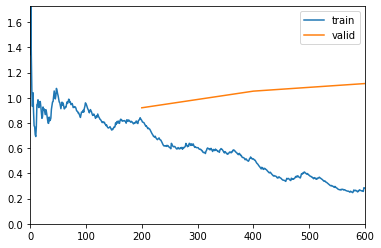

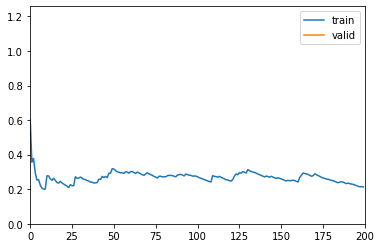

finished 2th bootstrap of size800


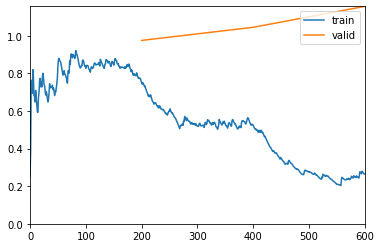

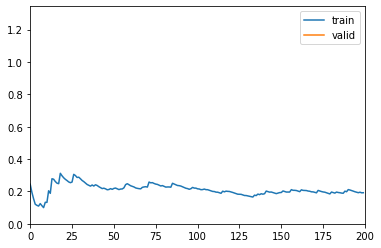

finished 3th bootstrap of size800


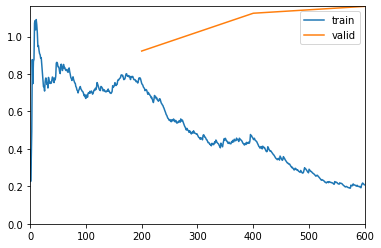

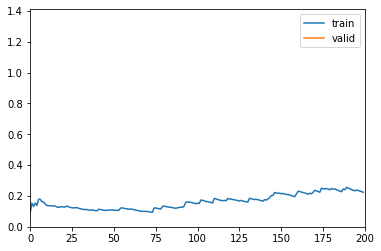

finished 4th bootstrap of size800


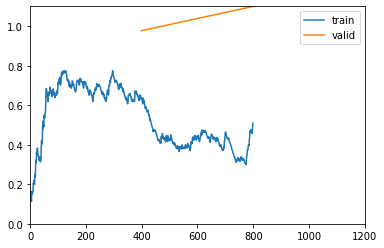

In [ ]:
res_yelp = xlnet_training_size_looper_dl([100, 200, 400, 800, 1600, 3200, 5000],  YELP, df_combine , 5, bs = 16)

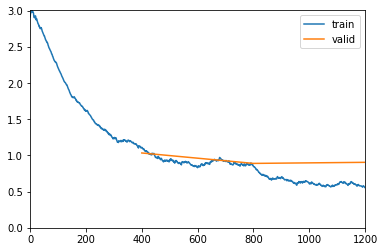

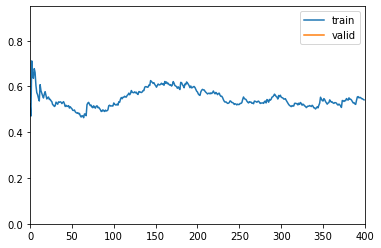

finished 0th bootstrap of size1600


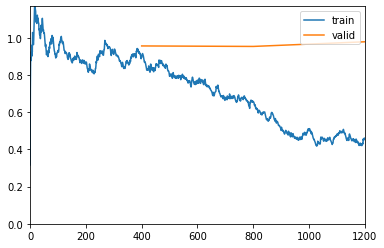

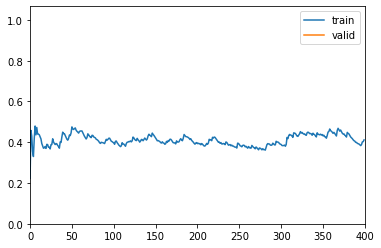

finished 1th bootstrap of size1600


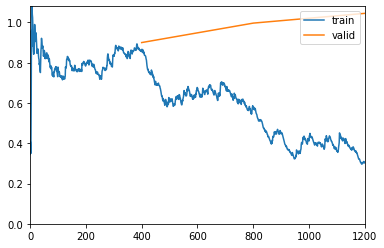

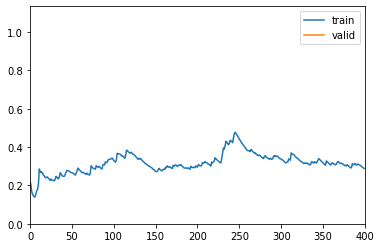

finished 2th bootstrap of size1600


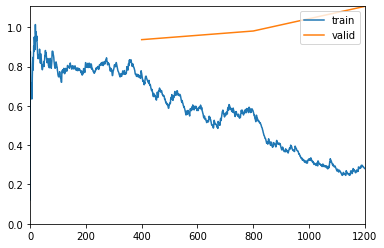

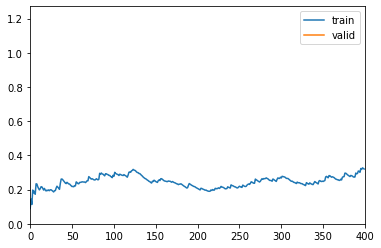

finished 3th bootstrap of size1600


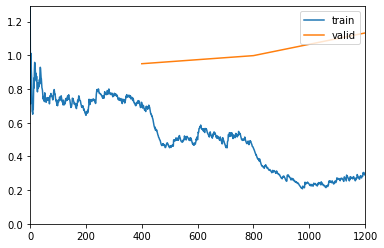

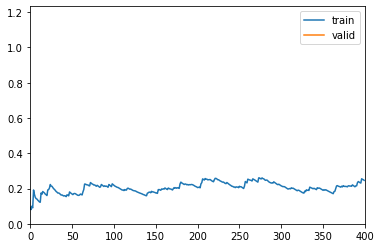

finished 4th bootstrap of size1600


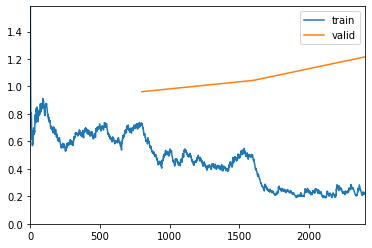

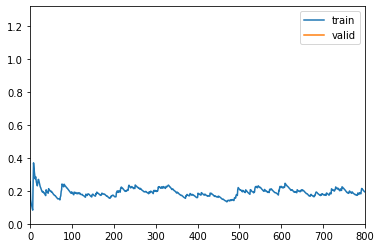

finished 0th bootstrap of size3200


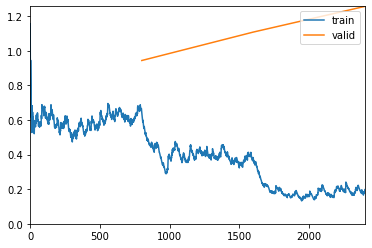

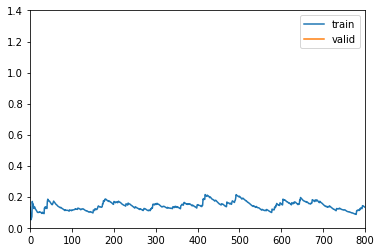

finished 1th bootstrap of size3200


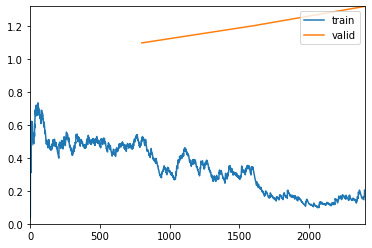

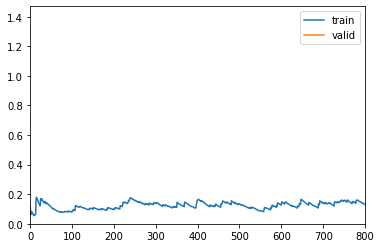

finished 2th bootstrap of size3200


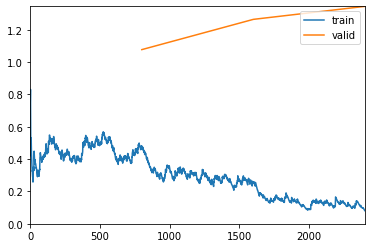

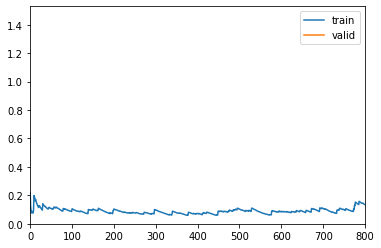

finished 3th bootstrap of size3200


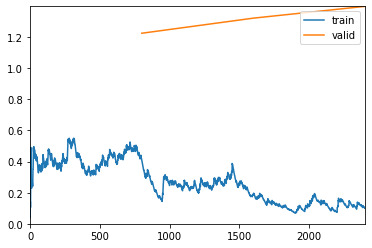

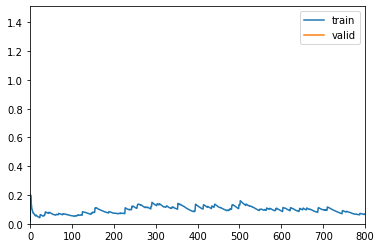

finished 4th bootstrap of size3200


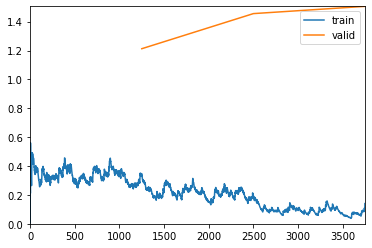

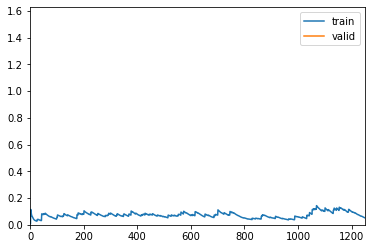

finished 0th bootstrap of size5000


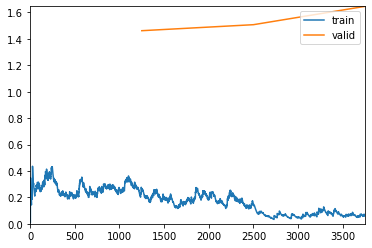

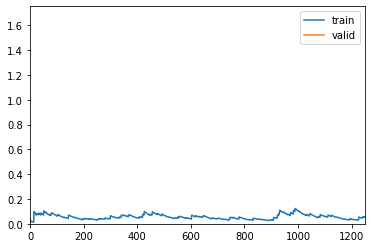

finished 1th bootstrap of size5000


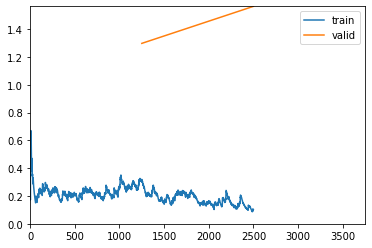

In [ ]:
res2_yelp = xlnet_training_size_looper_dl([1600, 3200, 5000],  YELP, df_combine , 5, bs = 4)

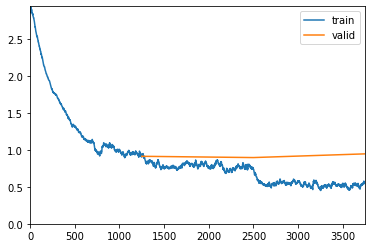

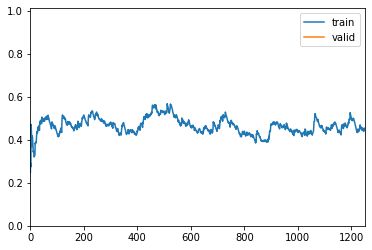

finished 0th bootstrap of size5000


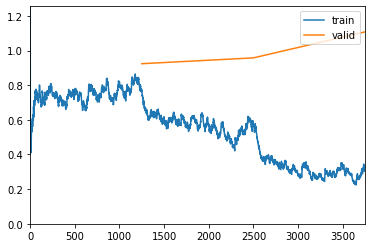

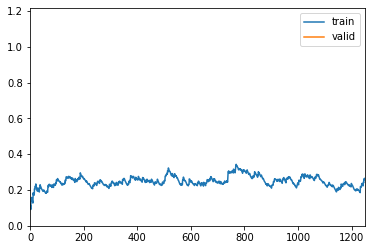

finished 1th bootstrap of size5000


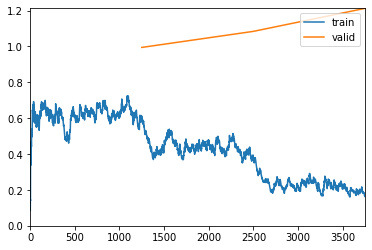

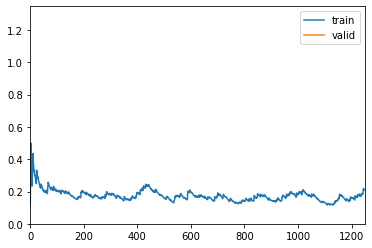

finished 2th bootstrap of size5000


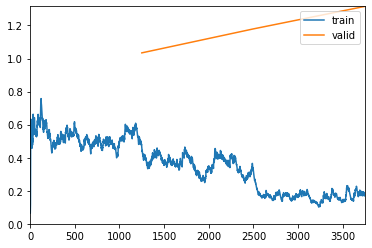

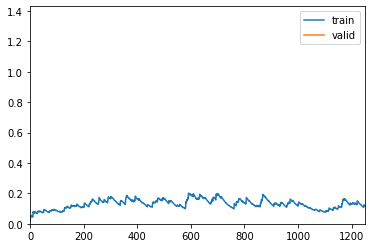

finished 3th bootstrap of size5000


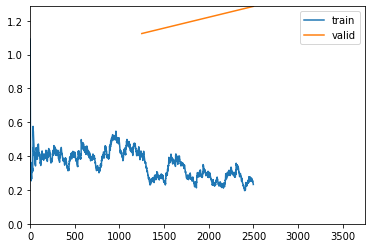

KeyboardInterrupt: 

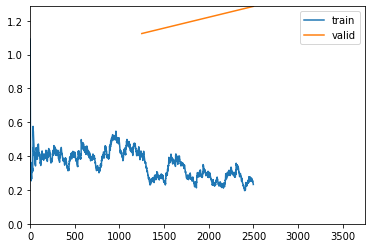

In [19]:
res3_yelp = xlnet_training_size_looper_dl([5000],  YELP, df_combine , 5, bs = 4)

In [ ]:
res2_yelp.to_csv(YELP/"xlnet_stage2_yelp.csv", index = False)

In [ ]:
accus.append(("xlnet", n, accu))

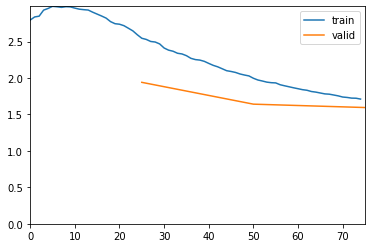

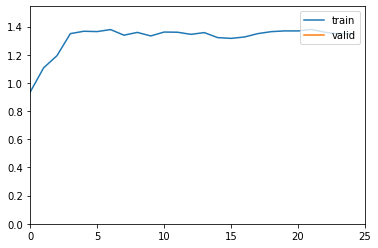

finished 0th bootstrap of size100


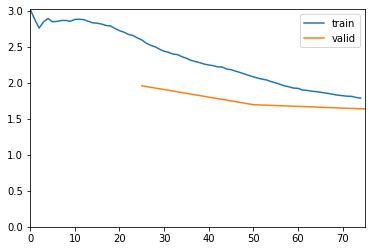

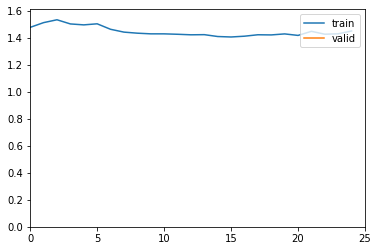

finished 1th bootstrap of size100


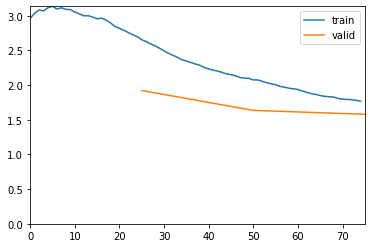

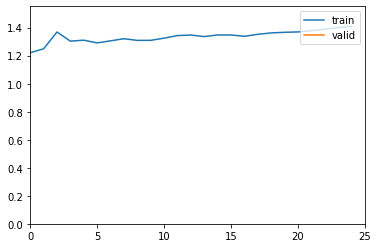

finished 2th bootstrap of size100


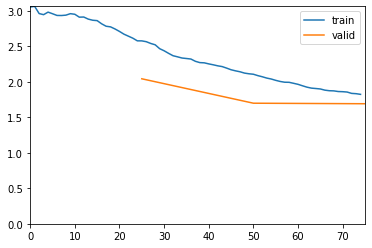

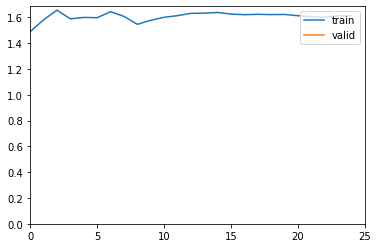

finished 3th bootstrap of size100


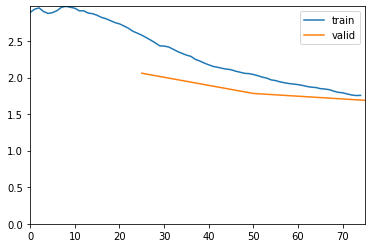

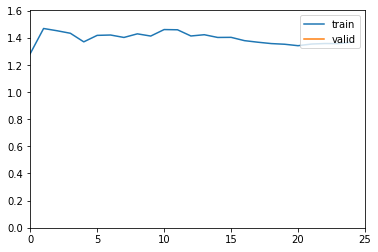

finished 4th bootstrap of size100


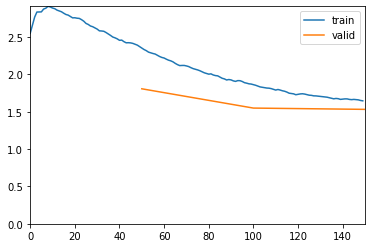

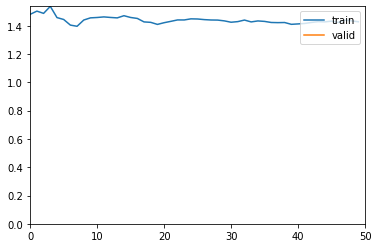

finished 0th bootstrap of size200


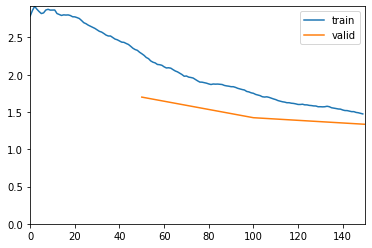

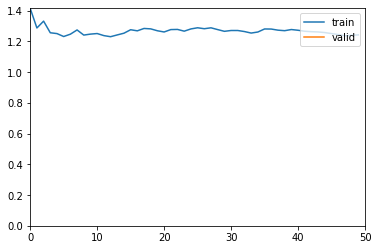

finished 1th bootstrap of size200


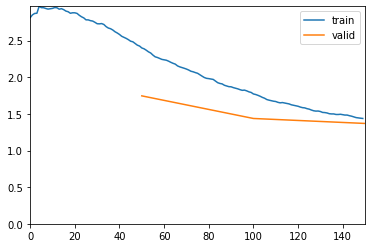

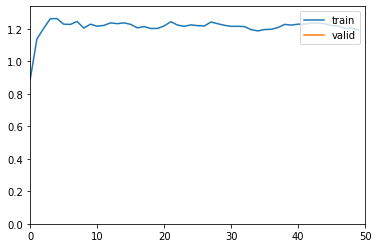

finished 2th bootstrap of size200


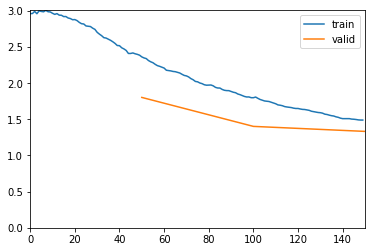

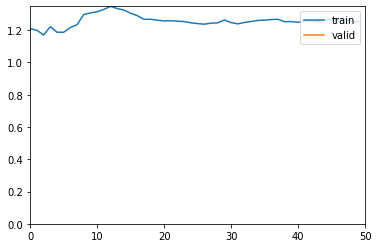

finished 3th bootstrap of size200


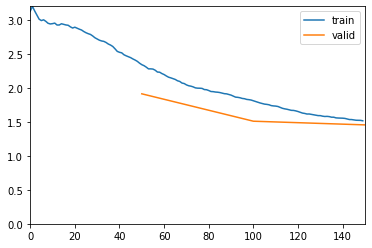

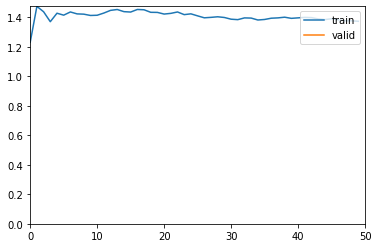

finished 4th bootstrap of size200


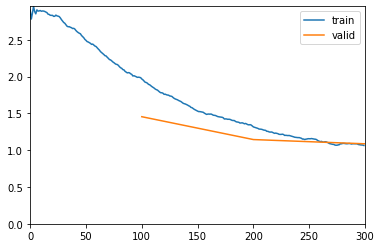

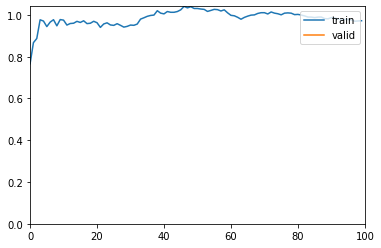

finished 0th bootstrap of size400


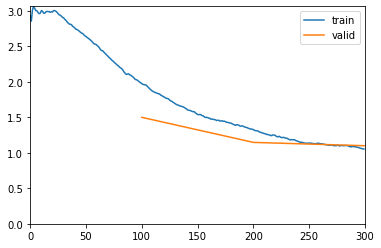

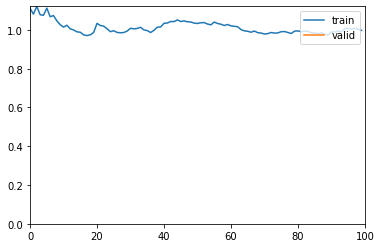

finished 1th bootstrap of size400


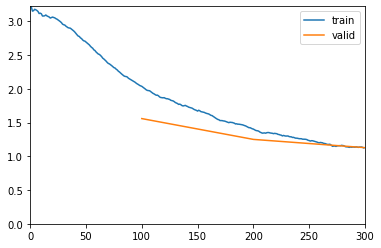

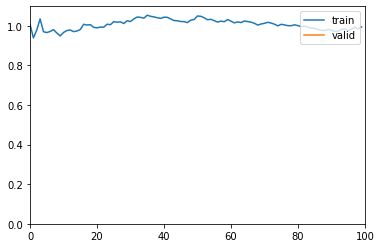

finished 2th bootstrap of size400


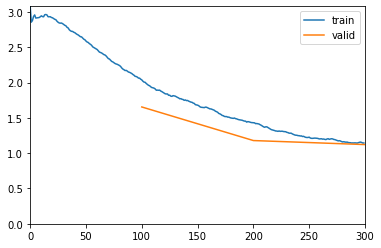

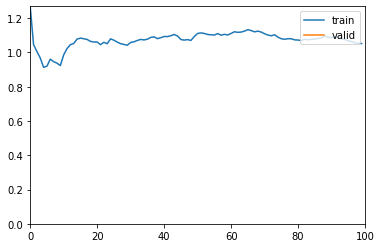

finished 3th bootstrap of size400


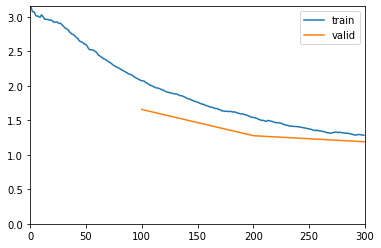

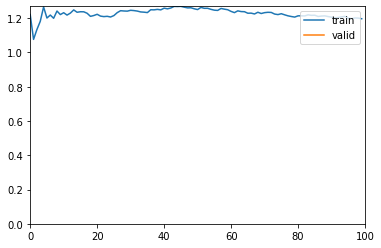

finished 4th bootstrap of size400


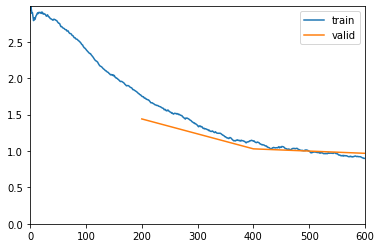

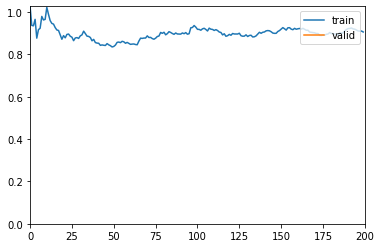

finished 0th bootstrap of size800


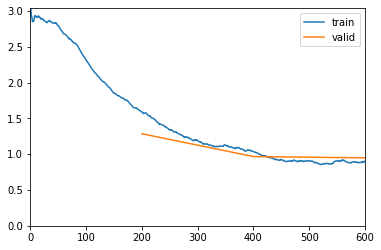

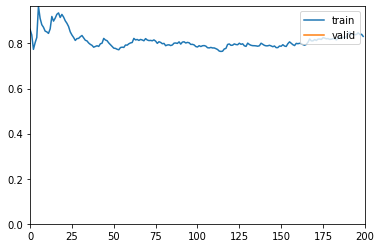

finished 1th bootstrap of size800


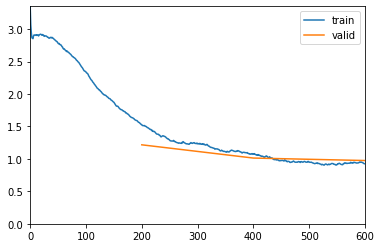

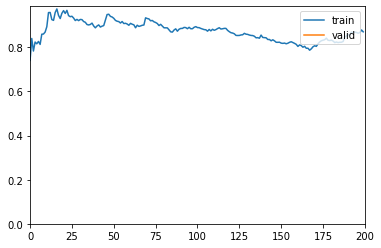

finished 2th bootstrap of size800


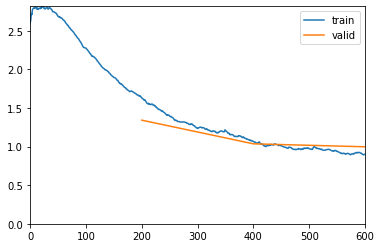

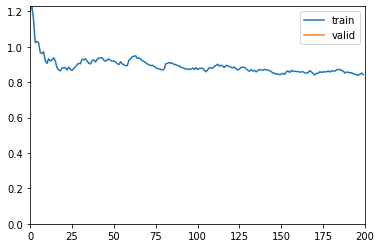

finished 3th bootstrap of size800


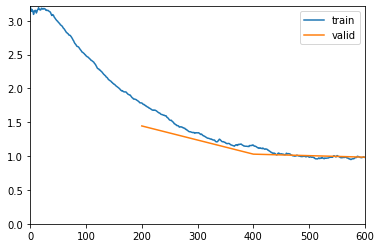

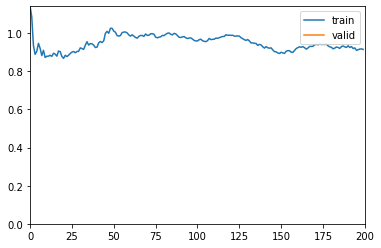

finished 4th bootstrap of size800


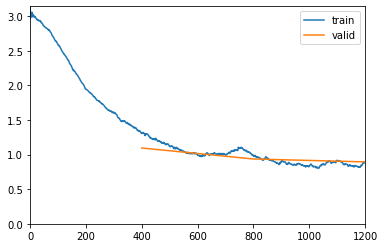

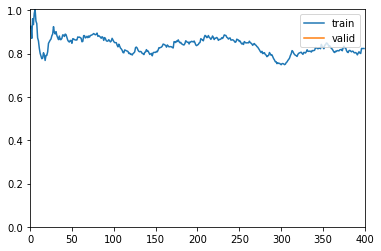

finished 0th bootstrap of size1600


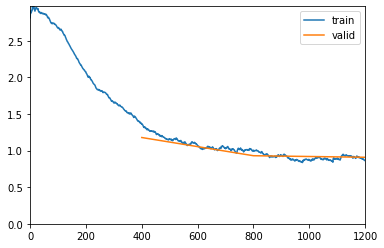

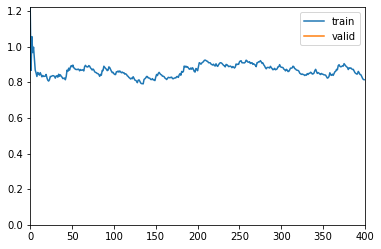

finished 1th bootstrap of size1600


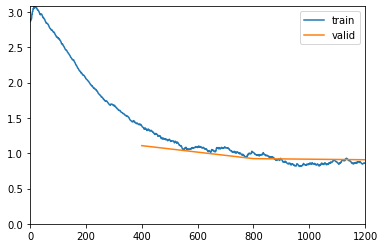

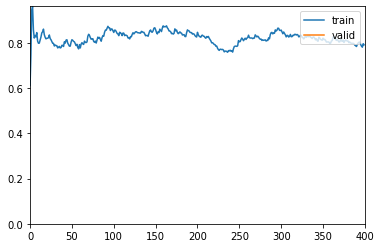

finished 2th bootstrap of size1600


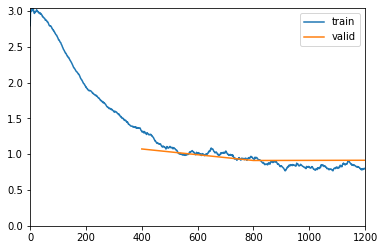

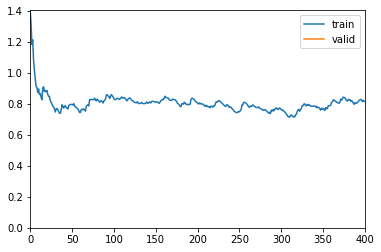

finished 3th bootstrap of size1600


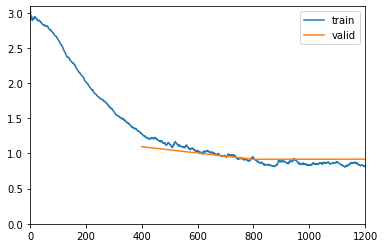

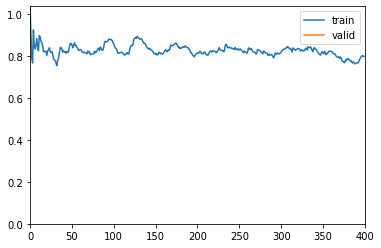

finished 4th bootstrap of size1600


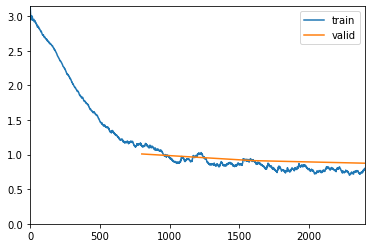

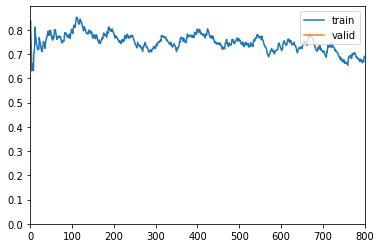

finished 0th bootstrap of size3200


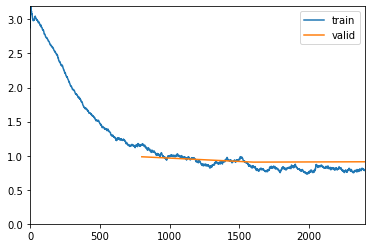

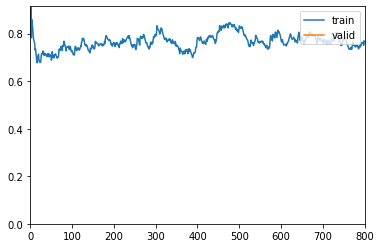

finished 1th bootstrap of size3200


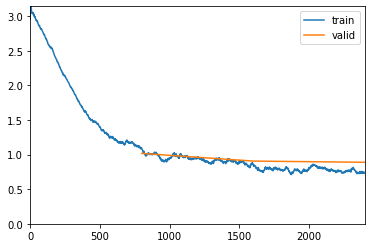

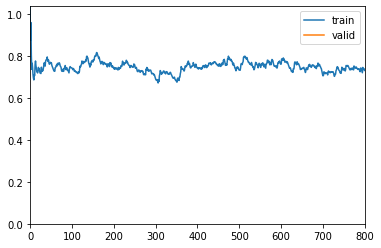

finished 2th bootstrap of size3200


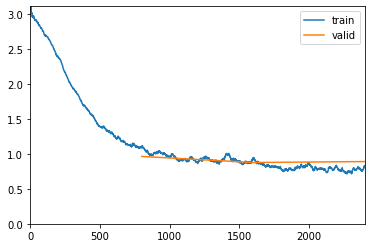

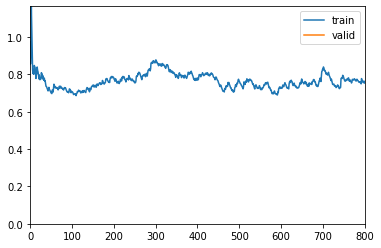

finished 3th bootstrap of size3200


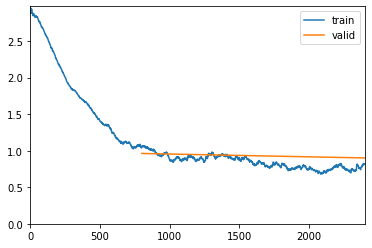

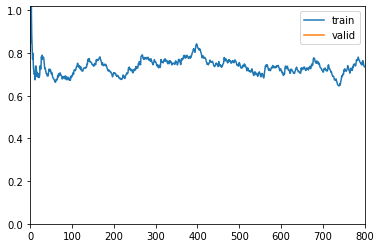

finished 4th bootstrap of size3200


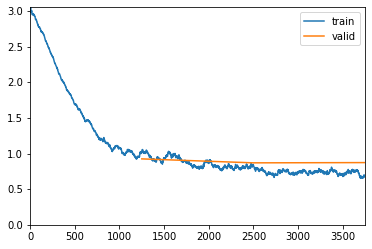

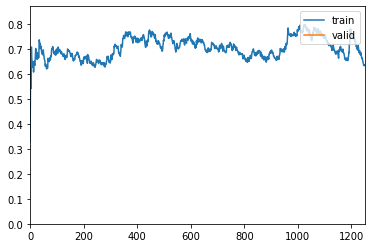

finished 0th bootstrap of size5000


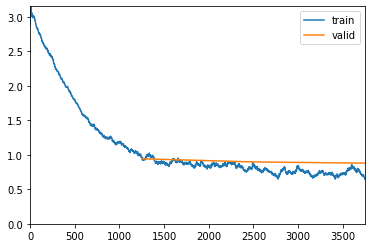

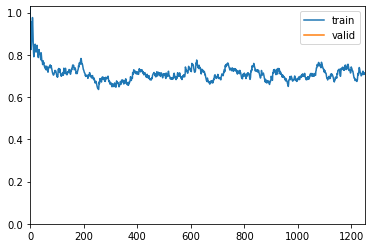

finished 1th bootstrap of size5000


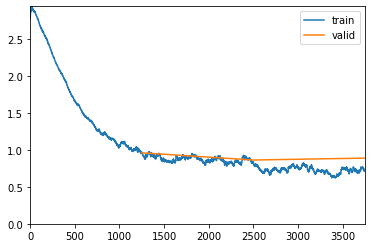

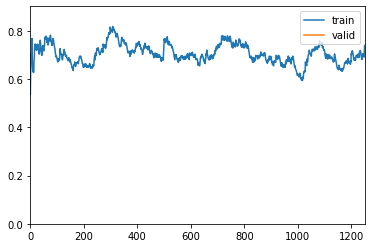

finished 2th bootstrap of size5000


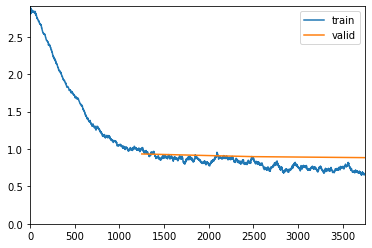

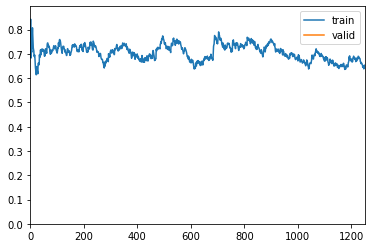

finished 3th bootstrap of size5000


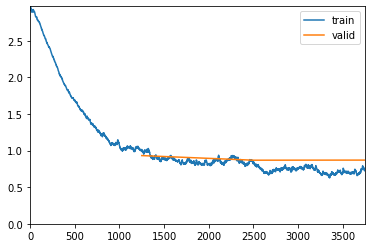

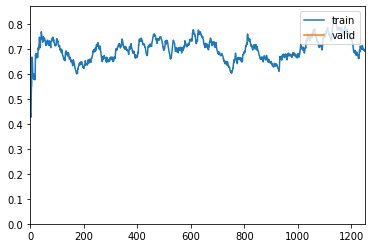

finished 4th bootstrap of size5000


In [46]:
res_yelp_adjusted = xlnet_training_size_looper_dl([100, 200, 400, 800, 1600, 3200, 5000],  YELP, df_combine , 5, bs = 4)

In [ ]:
res_yelp_adjusted.to_csv(YELP/"xlnet_stage2_yelp_adjusted.csv", index = False)

## Amazon data

In [18]:
df = AMAZON_TRAIN
df.head(2)


NameError: name 'AMAZON_TRAIN' is not defined

In [17]:
label_cols = 'class'
text_cols = 'review'

x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(df[text_cols], df[label_cols], range(len(df)), test_size=2000, random_state=0)


train = pd.DataFrame({text_cols: x_train, 
                      label_cols: y_train})
val = pd.DataFrame({text_cols: x_test, 
                      label_cols: y_test})
train = train.reset_index()[[text_cols, label_cols]]
val = val.reset_index()[[text_cols, label_cols]]

train['is_valid'] = 0
val['is_valid'] = 1
#combine two dataframe into one
df_combine = pd.concat([train, val], axis=0)
val

KeyError: 'review'

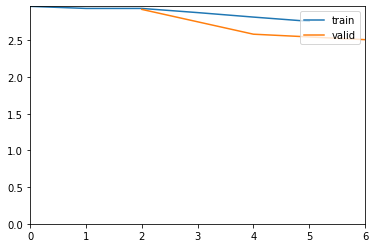

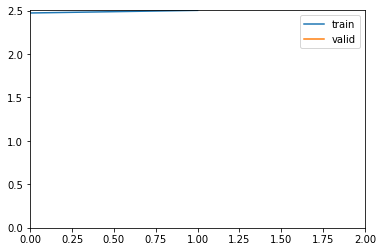

finished 0th bootstrap of size100


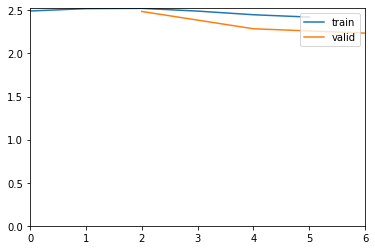

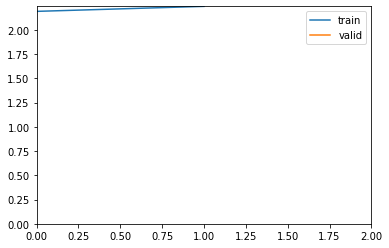

finished 1th bootstrap of size100


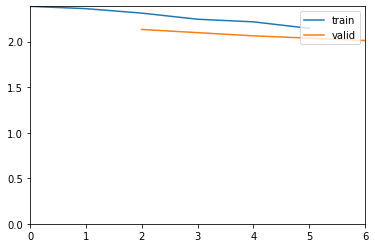

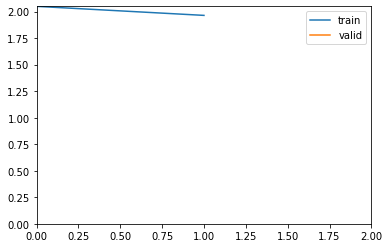

finished 2th bootstrap of size100


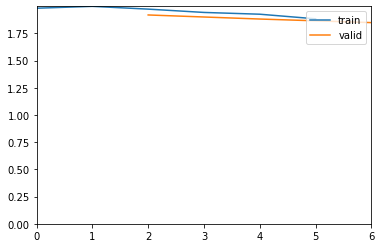

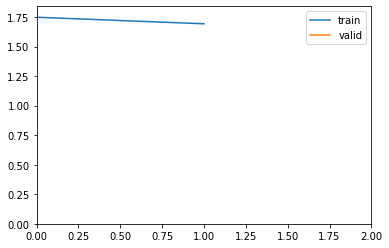

finished 3th bootstrap of size100


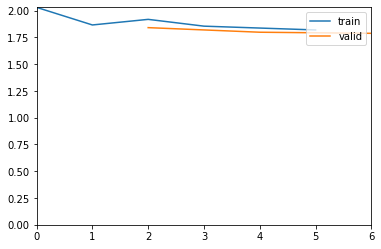

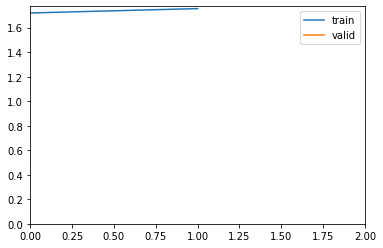

finished 4th bootstrap of size100


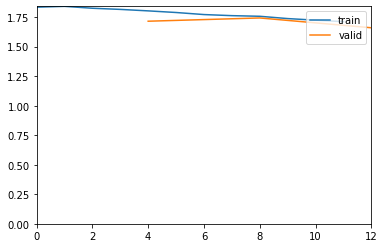

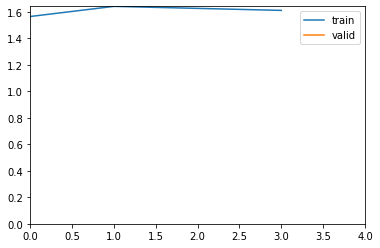

finished 0th bootstrap of size200


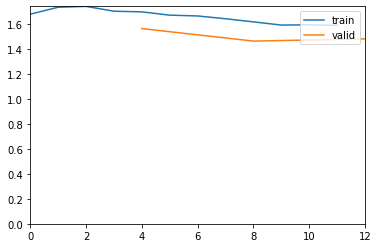

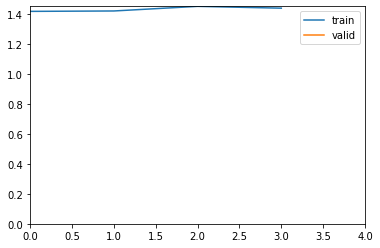

finished 1th bootstrap of size200


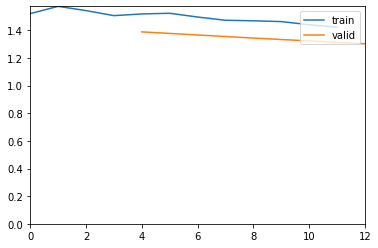

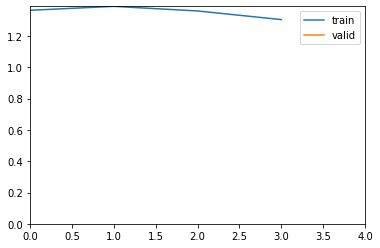

finished 2th bootstrap of size200


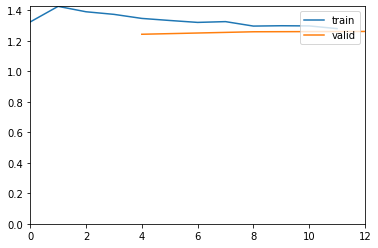

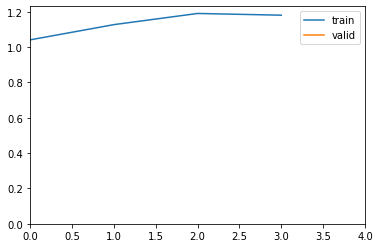

finished 3th bootstrap of size200


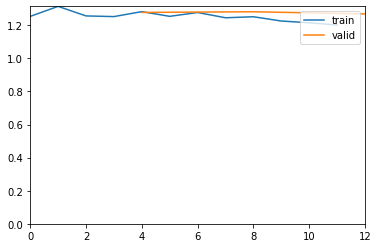

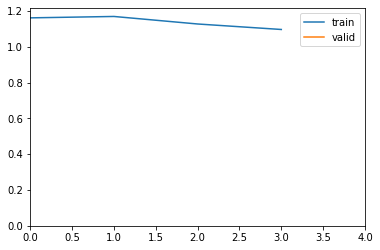

finished 4th bootstrap of size200


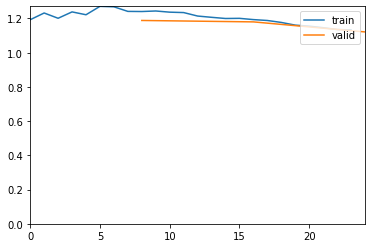

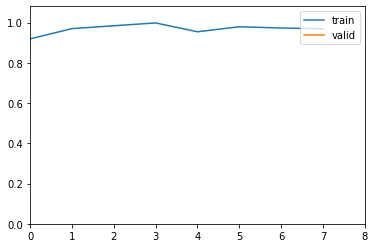

finished 0th bootstrap of size400


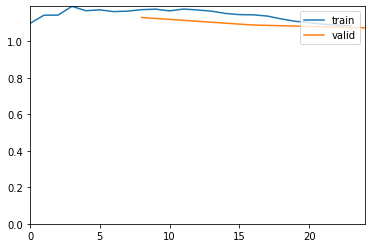

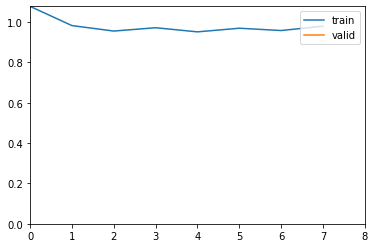

finished 1th bootstrap of size400


RuntimeError: CUDA out of memory. Tried to allocate 102.00 MiB (GPU 0; 15.90 GiB total capacity; 14.93 GiB already allocated; 29.88 MiB free; 295.34 MiB cached)

In [16]:
res_amazon = xlnet_training_size_looper_dl([100, 200, 400, 800, 1600, 3200, 5000],  AMAZON, df_combine , 5, bs = 48)

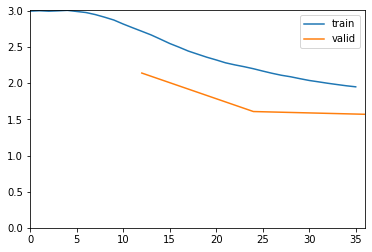

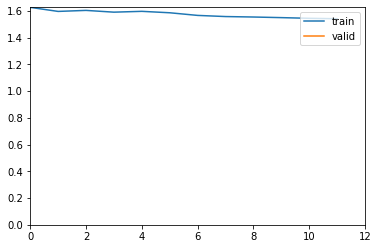

finished 0th bootstrap of size400


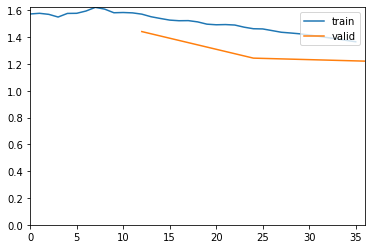

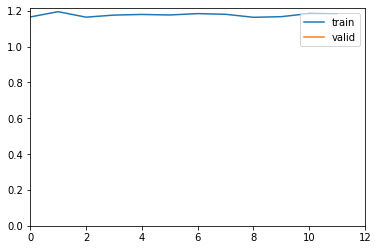

finished 1th bootstrap of size400


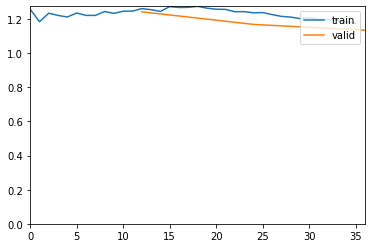

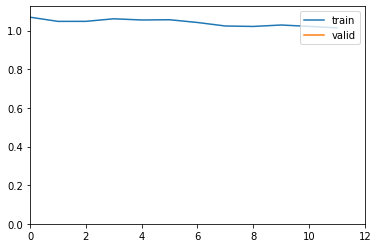

finished 2th bootstrap of size400


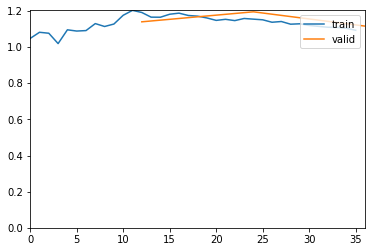

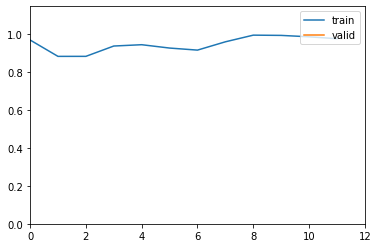

finished 3th bootstrap of size400


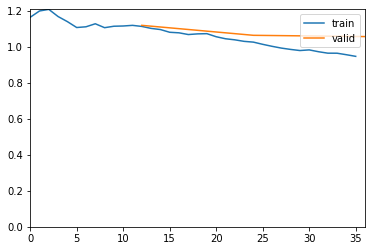

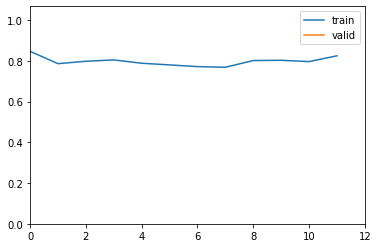

finished 4th bootstrap of size400


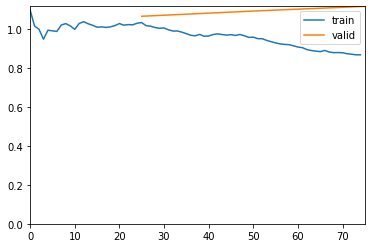

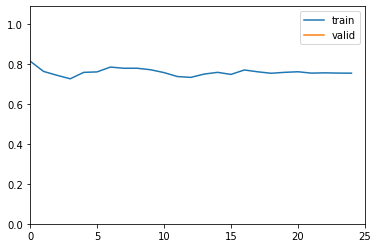

finished 0th bootstrap of size800


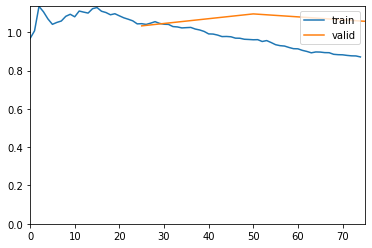

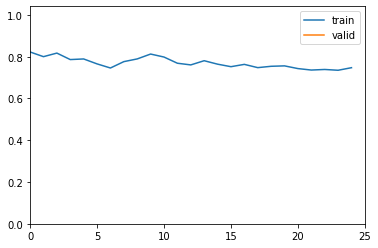

finished 1th bootstrap of size800


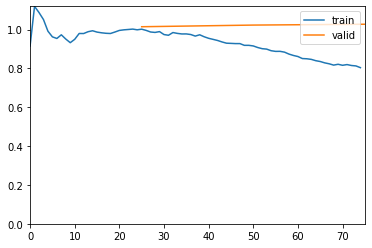

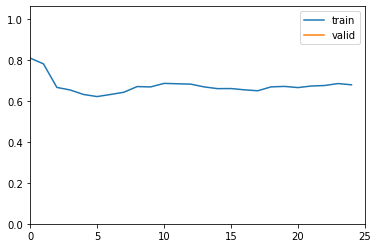

finished 2th bootstrap of size800


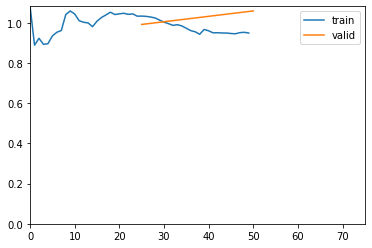

RuntimeError: CUDA out of memory. Tried to allocate 78.00 MiB (GPU 0; 15.90 GiB total capacity; 14.65 GiB already allocated; 65.88 MiB free; 546.90 MiB cached)

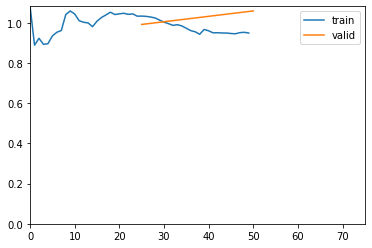

In [17]:
res2_amazon = xlnet_training_size_looper_dl([ 400, 800, 1600, 3200, 5000],  AMAZON, df_combine , 5, bs = 32)

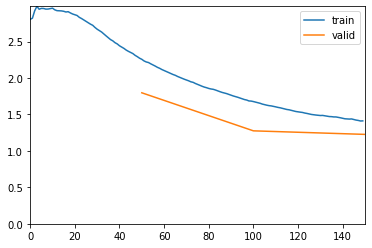

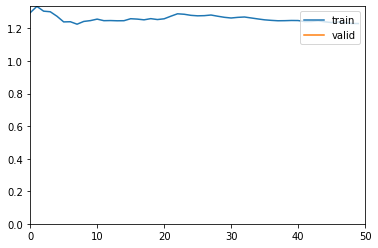

finished 0th bootstrap of size800


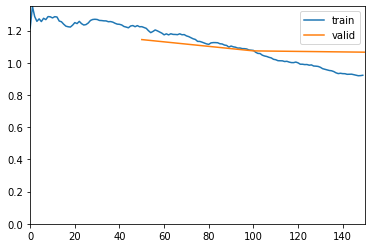

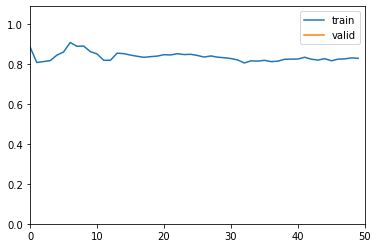

finished 1th bootstrap of size800


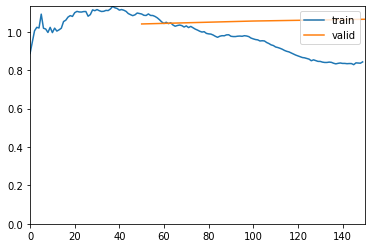

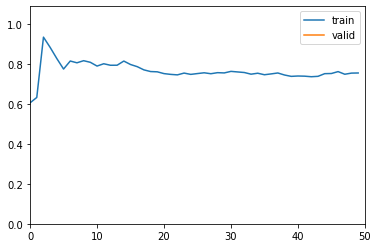

finished 2th bootstrap of size800


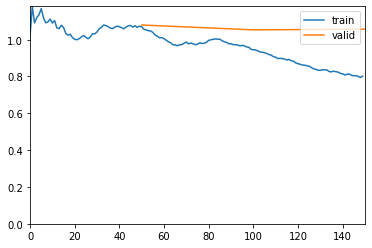

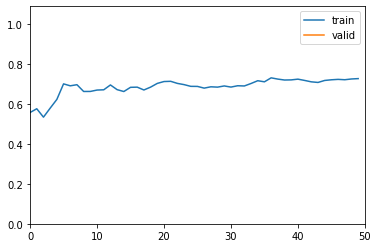

finished 3th bootstrap of size800


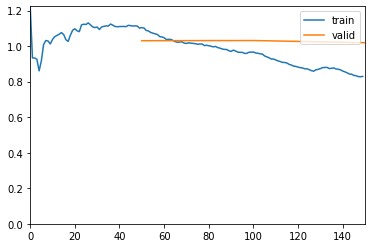

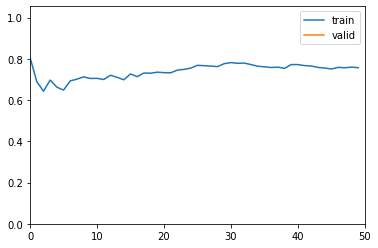

finished 4th bootstrap of size800


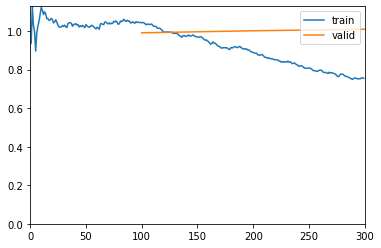

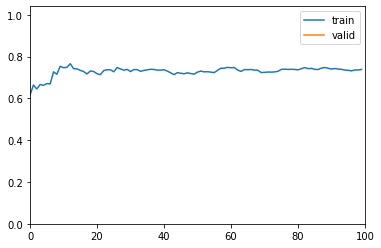

finished 0th bootstrap of size1600


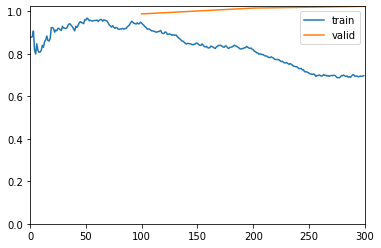

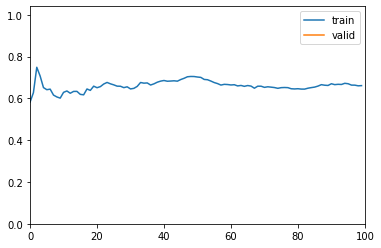

finished 1th bootstrap of size1600


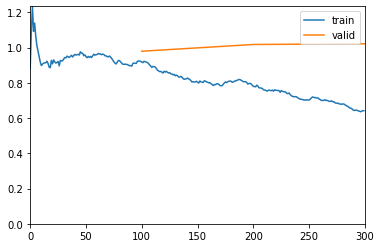

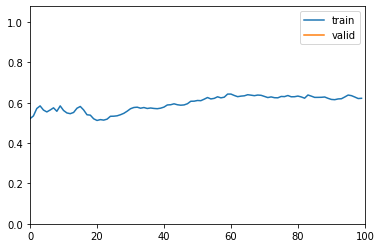

finished 2th bootstrap of size1600


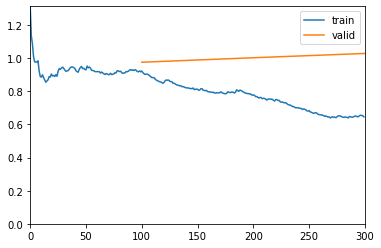

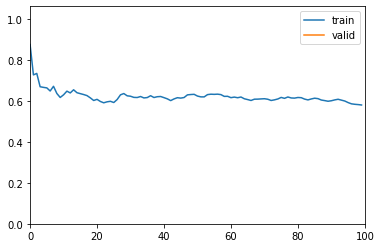

finished 3th bootstrap of size1600


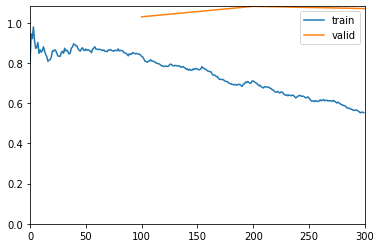

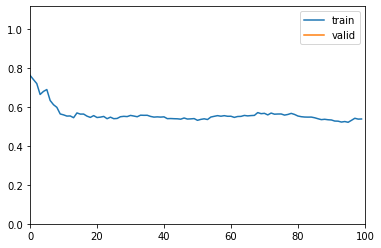

finished 4th bootstrap of size1600


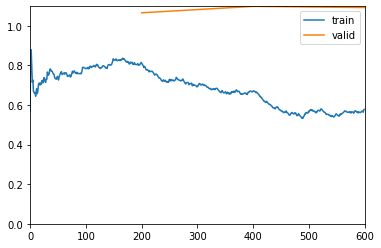

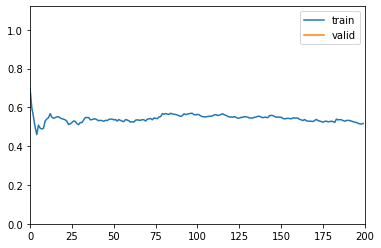

finished 0th bootstrap of size3200


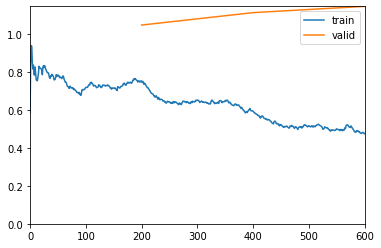

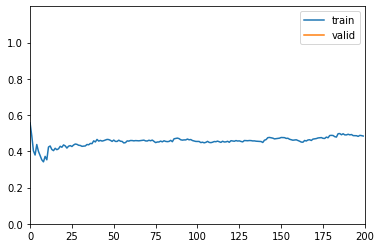

finished 1th bootstrap of size3200


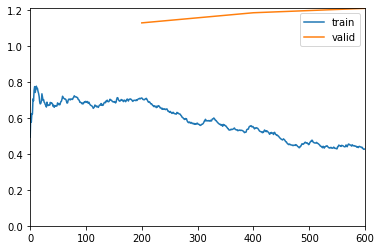

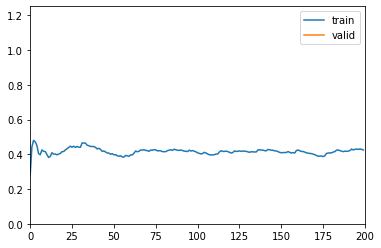

finished 2th bootstrap of size3200


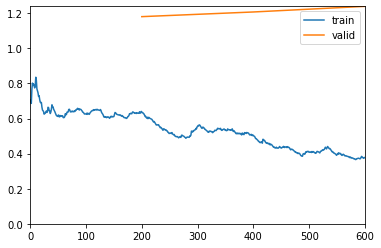

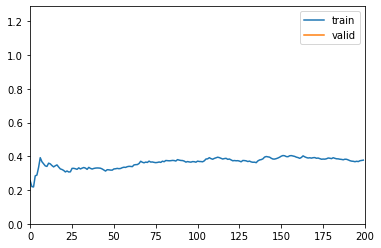

finished 3th bootstrap of size3200


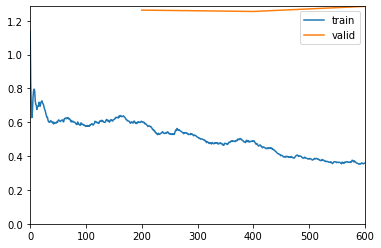

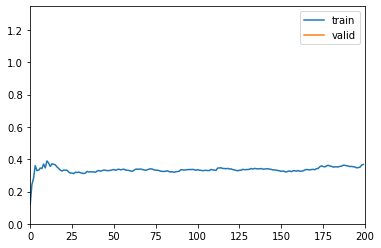

finished 4th bootstrap of size3200


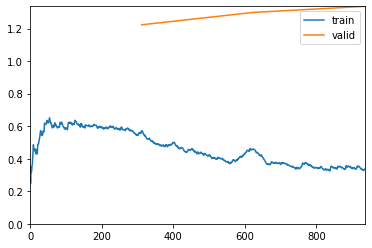

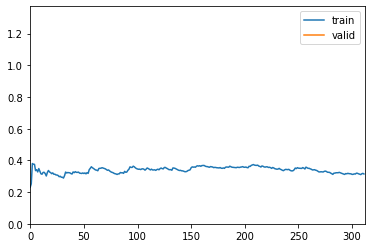

finished 0th bootstrap of size5000


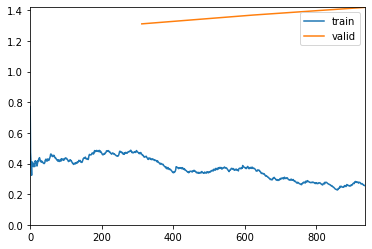

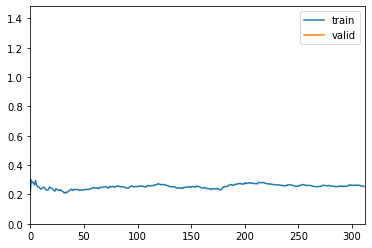

finished 1th bootstrap of size5000


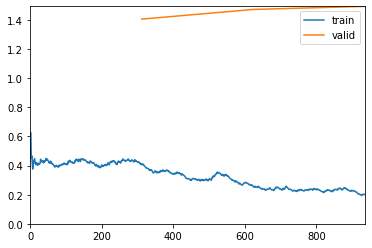

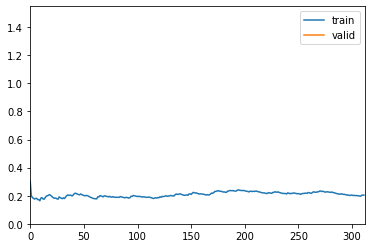

finished 2th bootstrap of size5000


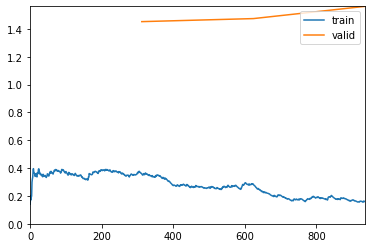

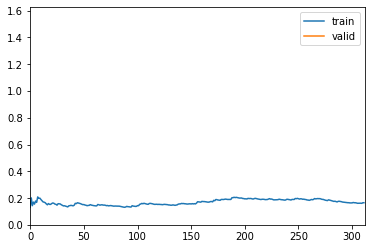

finished 3th bootstrap of size5000


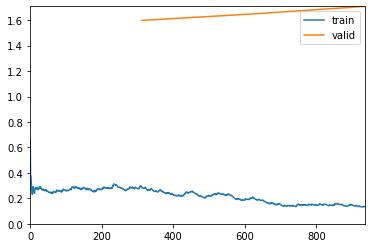

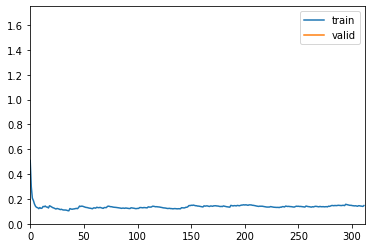

finished 4th bootstrap of size5000


In [18]:
res2_amazon = xlnet_training_size_looper_dl([800, 1600, 3200, 5000],  AMAZON, df_combine , 5, bs = 16)

In [20]:
res2_amazon.to_csv(AMAZON/"xlnet_stage2_amazon.csv", index = False)


In [21]:
torch.cuda.empty_cache()

## Customer data

In [15]:
df = CUSTOMER_TRAIN
df.head(2)

product  \
0                                    Debt collection   
1  Credit reporting, credit repair services, or o...   

                                           complaint  
0  For over a month, I have been getting calls fr...  
1  XX/XX/XXXX, a series on letters to XXXX XXXX X...

In [16]:
label_cols = 'product'
text_cols = 'complaint'

x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(df[text_cols], df[label_cols], range(len(df)), test_size=2000, random_state=0)


train = pd.DataFrame({text_cols: x_train, 
                      label_cols: y_train})
val = pd.DataFrame({text_cols: x_test, 
                      label_cols: y_test})
train = train.reset_index()[[text_cols, label_cols]]
val = val.reset_index()[[text_cols, label_cols]]

train['is_valid'] = 0
val['is_valid'] = 1
#combine two dataframe into one
df_combine = pd.concat([train, val], axis=0)
df_combine.head(2)

complaint  \
0  I have had an American Express XXXX XXXX XXXX ...   
1  Upon a surprise transfer of my loan in XXXX, I...   

                       product  is_valid  
0  Credit card or prepaid card         0  
1                     Mortgage         0

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Payday loan, Other financial service
  if getattr(ds, 'warn', False): warn(ds.warn)


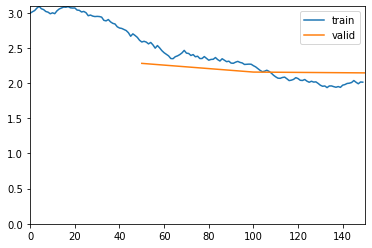

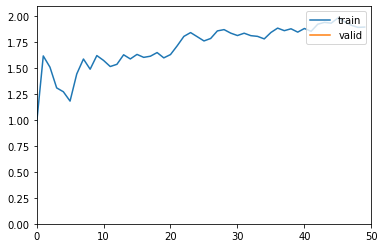

finished 0th bootstrap of size100


/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Money transfers, Other financial service, Payday loan, title loan, or personal loan, Payday loan, Prepaid card
  if getattr(ds, 'warn', False): warn(ds.warn)


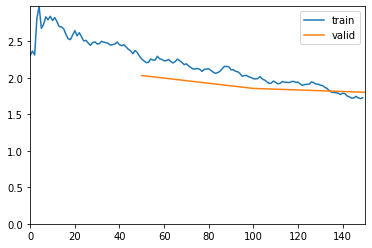

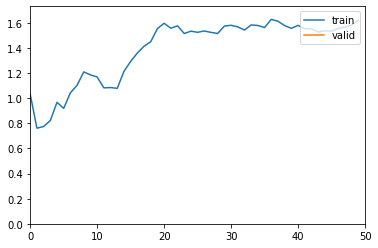

finished 1th bootstrap of size100


/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Other financial service, Prepaid card, Money transfers, Payday loan, title loan, or personal loan
  if getattr(ds, 'warn', False): warn(ds.warn)


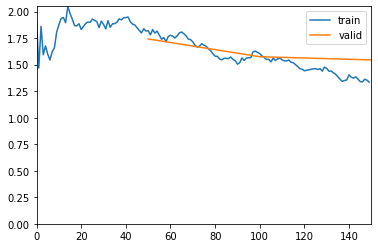

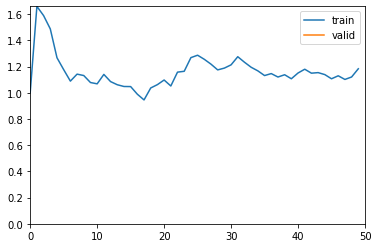

finished 2th bootstrap of size100


/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Payday loan, Other financial service, Money transfers, Payday loan, title loan, or personal loan
  if getattr(ds, 'warn', False): warn(ds.warn)


In [ ]:
res_customer = xlnet_training_size_looper_dl([100, 200, 400, 800, 1600, 3200, 5000],  CUSTOMER, df_combine , 18, bs = 2)

In [23]:
torch.cuda.empty_cache()

# export functions to .py file

In [7]:
!python notebook2script.py XLNET_GPT2.ipynb

Converted XLNET_GPT2.ipynb to exp/nb_XLNET.py
